In [ ]:
# Source:
# Tutorial: https://mlexplained.com/2019/02/15/building-an-lstm-from-scratch-in-pytorch-lstms-in-depth-part-1
# /#annotations:1lD6dgiMEeqYX9dq3ex1Jw
# Code: https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/deep_dives/lstm_from_scratch.ipynb

# Building an LSTM from scratch

In this notebook, we'll be building our own LSTM and delving into why it performs so well across a wide range of tasks.


## The Basics of the LSTM

Before we actually build the LSTM, we'll need to understand its basic mechansim.

The below diagram shows the flow of information in an LSTM cell


In [59]:
import os
from IPython.display import Image

# NOTE: this is where we start jupyter-notebook command
pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

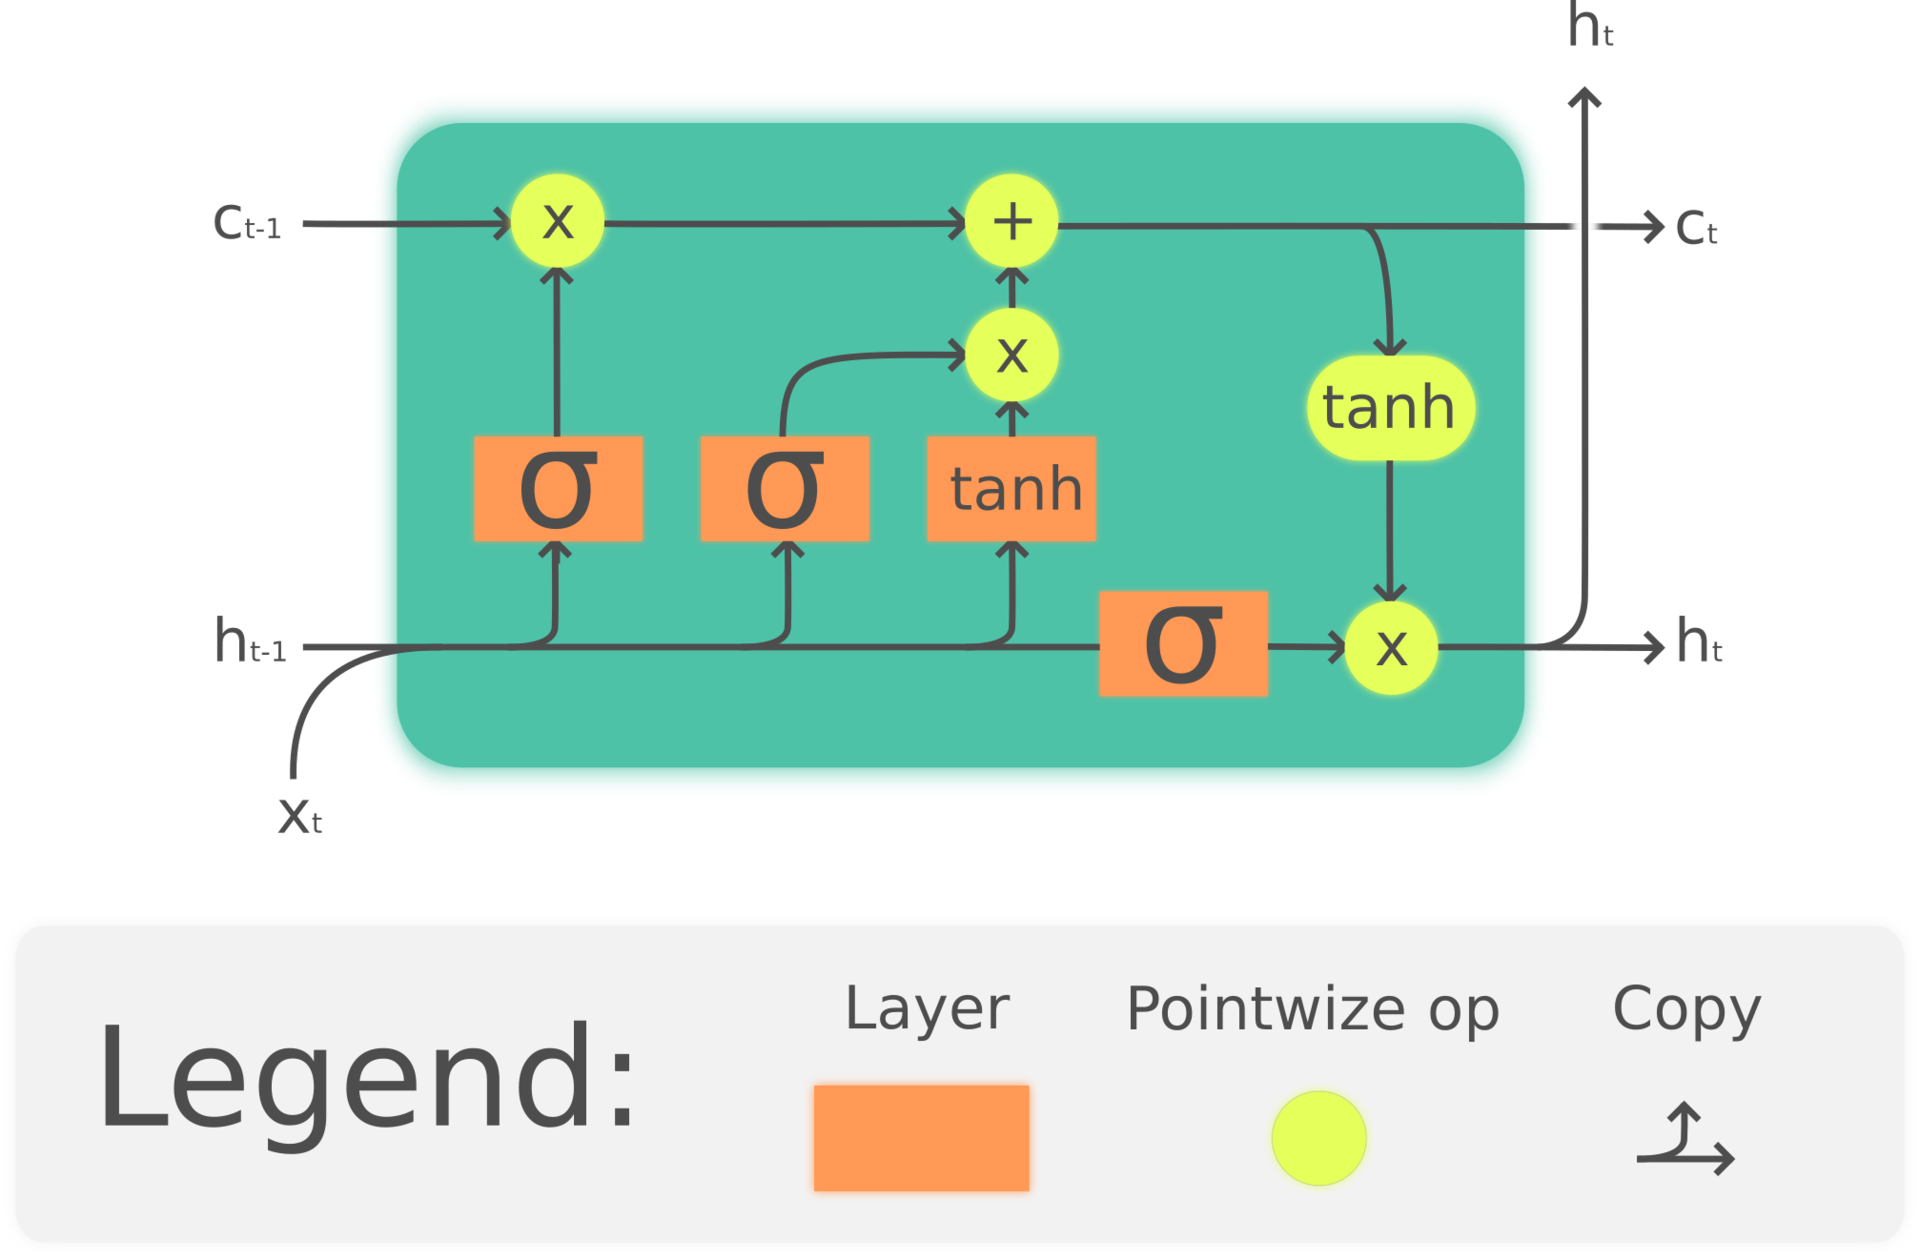

In [60]:
Image(filename=pth + '/images/The_LSTM_cell.png')

The equation for the LSTM's forward pass logic looks like this:

\begin{array}{ll} \\
             i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
             f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
             g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
             o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
            c_t = f_t * c_{(t-1)} + i_t * g_t \\
             h_t = o_t * \tanh(c_t) \\
         \end{array}

##### LSTM's Update Rule: 

$$
c_t = f_t * c_{(t-1)} + i_t * g_t \\
$$

$c_t =$ the new cell state, which is basically the memory of the LSTM. 

$f_t =$ the "forget gate": it dictates how much of the previous cell state to **retain** (but is slightly confusingly named the forget gate). 

$i_t =$ the "input gate" and dictates how much to update the cell state with new information.

$g_t =$ the information we use to update the cell state.

Basically, an LSTM chooses to keep a certain portion of its previous cell state and add a certain amount of new information. These proportions are controlled using gates.


### Contrasting LSTM Update Rule with Simpler RNN's Update Rule 

##### RNN's Update Rule: 

$$ 
c_t = \tanh(W_hc_{t-1} + W_ix_t) \\
$$

(To make the contrast clearer, I'm representing the hidden state of the RNN as $ c_t $.)

As you can see, there is a huge difference between the simple RNN's update rule and the LSTM's update rule. Whereas the RNN computes the new hidden state from scratch based on the previous hidden state and the input, the LSTM computes the new hidden state by choosing what to **add** to the current state. This is similar to how ResNets learn: they learn what to add to the current state/block instead of directly learning the new state. In other words, LSTMs are great primarily because they are **additive**. We'll formalize this intuition later when we examine the gradient flow, but this is the basic idea behind the LSTM.


Side Note: LSTM has two "hidden states": $ c_t $ and $ h_t $. Intuitively, $ c_t $ is the "internal" hidden state that retains important information for longer timesteps, whereas $ h_t $ is the "external" hidden state that exposes that information to the outside world.


Side Note: the bias terms are redundant. The reason they are there is for compatibility with the CuDNN backend. (Until we touch on CuDNN, we'll use a single bias term.)


# Implementing The LSTM

In [61]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Parameter
#from torch.Tensor import Tensor
import torch.tensor as Tensor
import torch.optim as optim

from typing import * # for Optional


In [6]:
from enum import IntEnum


class Dimension(IntEnum):
    batch = 0
    seq = 1
    feature = 2

In [7]:
class NaiveLSTM(nn.Module):
    
    # NOTE: terrible, but need to use snake-case args hre to match nn.RNN's inputs, since this will
    # be passed in the LanguageModel as parameter
    def __init__(self, input_size: int, hidden_size: int):
        
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # input gate's main variables
        self.W_ii = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hi = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = Parameter(torch.Tensor(hidden_size))
        
        # forget gate's main variables
        self.W_if = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hf = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = Parameter(torch.Tensor(hidden_size))
        
        # g_t gate's main variables
        self.W_ig = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_hg = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = Parameter(torch.Tensor(hidden_size))
        
        # output gate's main variables
        self.W_io = Parameter(torch.Tensor(input_size, hidden_size))
        self.W_ho = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = Parameter(torch.Tensor(hidden_size))
        
        # initialize the weights
        self.initWeights()
        
        
    def initWeights(self):
        for param in self.parameters():
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data)
            else:
                nn.init.zeros_(param.data)
                
    def forward(self, X: torch.Tensor,
                initStates: Optional[Tuple[torch.Tensor, torch.Tensor]]=None
                ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Assumption: x is of shape (batch, sequence, feature)
        
        :param X: 
        :param initStates: 
        :return: 
        """
        
        batchSize, seqSize, featureSize = X.size()
        hiddenSeqs = []
        
        if initStates is None:
            h_t, c_t = torch.zeros(self.hidden_size).to(X.device), torch.zeros(self.hidden_size).to(X.device)
        else:
            h_t, c_t = initStates
            
        # Iterating over the time steps
        # Applying the LSTM equations in the repeating module for each timestep. 
        for t in range(seqSize):
            x_t = X[:, t, :] # picking a dimension by time in the 3-dim tensor that is X
            
            
            # note: the `@` is doing matrix multiplication between the tensors, and dimensions must match.
            
            # input gate: 
            i_t = torch.sigmoid(x_t @ self.W_ii + h_t @ self.W_hi + self.b_i)
            # forget gate:
            f_t = torch.sigmoid(x_t @ self.W_if + h_t @ self.W_hf + self.b_f)
            # g_t gate:
            g_t = torch.tanh(x_t @ self.W_ig + h_t @ self.W_hg + self.b_g)
            # output gate: 
            o_t = torch.sigmoid(x_t @ self.W_io + h_t @ self.W_ho + self.b_o)
            # internal cell state
            c_t = f_t * c_t + i_t * g_t # LSTM is additive since it adds input info
            # external hidden state
            h_t = o_t * torch.tanh(c_t)
            
            # add the hidden state to the list while adding a 1-dim Tensor along
            # dimension Dimension.batch in the hidden state tensor. 
            hiddenSeqs.append(h_t.unsqueeze(Dimension.batch))
            
        # concat the hidden seqs along this dimension
        hiddenSeqs = torch.cat(hiddenSeqs, dim=Dimension.batch)
        
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hiddenSeqs = hiddenSeqs.transpose(Dimension.batch, Dimension.seq).contiguous()
        
        return hiddenSeqs, (h_t, c_t)

In [7]:
# Small example below to understand torch.cat and unsqueeze

x = torch.randn(2,1,4)
y = torch.randn(2,1,4)
z = torch.randn(2,1,4)
print(x.dim())
print(x.size())
print(x.unsqueeze(dim=0).size())
x = x.unsqueeze(dim = 0)
y = y.unsqueeze(dim = 0)
z = z.unsqueeze(dim = 0)
print("x size: ", x.size())
print("y size: ", y.size())
c = torch.cat([x,y,z], dim=0)

3
torch.Size([2, 1, 4])
torch.Size([1, 2, 1, 4])
x size:  torch.Size([1, 2, 1, 4])
y size:  torch.Size([1, 2, 1, 4])


In [8]:
x

tensor([[[[ 1.4082,  1.4102, -0.1815, -1.9977]],

         [[-0.8433, -1.3864, -1.3896, -1.3310]]]])

In [9]:
y

tensor([[[[ 1.0907, -1.2017, -0.0153, -1.1091]],

         [[-1.3927, -0.6749,  0.3847,  0.9836]]]])

In [10]:
z

tensor([[[[ 0.0119, -1.3384,  0.2575, -0.0648]],

         [[-0.0007,  0.6969, -0.4250, -1.1011]]]])

In [11]:
print(c)
print(c.dim())
print(c.size())

tensor([[[[ 1.4082,  1.4102, -0.1815, -1.9977]],

         [[-0.8433, -1.3864, -1.3896, -1.3310]]],


        [[[ 1.0907, -1.2017, -0.0153, -1.1091]],

         [[-1.3927, -0.6749,  0.3847,  0.9836]]],


        [[[ 0.0119, -1.3384,  0.2575, -0.0648]],

         [[-0.0007,  0.6969, -0.4250, -1.1011]]]])
4
torch.Size([3, 2, 1, 4])


In [ ]:
hs = torch.cat([x,y,z], dim=0)
hs = hs.transpose(0, 1).contiguous()
print(hs)

Testing NaiveLSMT class on some synthetic data:

In [78]:
### Testing the class on synthetic data

batchSize, seqLen, featureSize, hiddenSize = 5, 10, 32, 16
arr = torch.randn(batchSize, seqLen, featureSize)
lstm = NaiveLSTM(input_size=featureSize, hidden_size=hiddenSize)
lstm

NaiveLSTM()

In [16]:
hidSeqs, (ht, ct) = lstm(arr) # calls forward
hidSeqs.shape # TODO shouldn't this be (5, 10, 32)? ????

torch.Size([5, 10, 16])

# Testing the Implementation

Our testbed will be a character-level language modeling task. We'll be using the Brown Corpus which you can get via the commands below.

In [ ]:
# get data from: http://www.sls.hawaii.edu/bley-vroman/brown.txt
# by cmd line: (inside data folder)
# curl http://www.sls.hawaii.edu/bley-vroman/brown.txt -o "brown.txt" 

In [10]:
# Letting AllenNLP do the model training

from allennlp.data.dataset_readers import LanguageModelingReader
from allennlp.data.tokenizers import CharacterTokenizer
from allennlp.data.token_indexers import SingleIdTokenIndexer
from allennlp.data import Vocabulary
from allennlp.data.iterators import BasicIterator
from allennlp.training import Trainer
from sklearn.model_selection import train_test_split

In [11]:
charTokenizer = CharacterTokenizer(lowercase_characters=True)

reader = LanguageModelingReader(
    tokens_per_instance=500,
    tokenizer= charTokenizer, 
    token_indexers= {"tokens" : SingleIdTokenIndexer()}
)

fullData = reader.read(file_path=pth + "/LSTMModel/data/brown.txt")
trainData, validationData = train_test_split(fullData, random_state=0, test_size=0.1)

vocabulary = Vocabulary.from_instances(trainData)

iterator = BasicIterator(batch_size= 32)
iterator.index_with(vocab = vocabulary)


0it [00:00, ?it/s]

11/20/2019 02:58:25 - INFO - allennlp.data.dataset_readers.language_modeling -   Creating dataset from all text in file: /development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy/LSTMModel/data/brown.txt


  0%|          | 0/11994 [00:00<?, ?it/s]

 36%|███▌      | 4303/11994 [00:00<00:00, 43027.89it/s]

 77%|███████▋  | 9236/11994 [00:00<00:00, 44742.20it/s]

 97%|█████████▋| 11620/11994 [00:00<00:00, 34901.35it/s]

100%|██████████| 11994/11994 [00:00<00:00, 37725.12it/s]


1it [00:10, 10.48s/it]

453it [00:10,  7.34s/it]

852it [00:10,  5.13s/it]

1311it [00:10,  3.59s/it]

1769it [00:10,  2.52s/it]

2193it [00:10,  1.76s/it]

2630it [00:11,  1.23s/it]

3016it [00:11,  1.16it/s]

3436it [00:11,  1.65it/s]

3837it [00:11,  2.36it/s]

4299it [00:11,  3.38it/s]

4714it [00:11,  4.82it/s]

5163it [00:11,  6.88it/s]

5542it [00:11,  9.82it/s]

6045it [00:12, 14.02it/s]

6490it [00:12, 20.00it/s]

6949it [00:12, 28.52it/s]

7382it [00:12, 40.57it/s]

7772it [00:12, 57.60it/s]

8130it [00:12, 81.41it/s]

8449it [00:12, 113.72it/s]

8719it [00:12, 158.90it/s]

8973it [00:13, 220.35it/s]

9219it [00:13, 302.67it/s]

9462it [00:13, 408.79it/s]

9811it [00:13, 556.04it/s]

10210it [00:13, 749.50it/s]

10701it [00:13, 1004.94it/s]

11119it [00:13, 1301.52it/s]

11552it [00:13, 1646.81it/s]

11994it [00:14, 856.39it/s] 

11/20/2019 02:58:29 - INFO - allennlp.data.vocabulary -   Fitting token dictionary from dataset.


  0%|          | 0/10794 [00:00<?, ?it/s]

  2%|▏         | 172/10794 [00:00<00:06, 1719.62it/s]

  3%|▎         | 328/10794 [00:00<00:06, 1665.35it/s]

  5%|▍         | 504/10794 [00:00<00:06, 1684.79it/s]

  6%|▋         | 684/10794 [00:00<00:05, 1716.05it/s]

  8%|▊         | 866/10794 [00:00<00:05, 1743.70it/s]

 10%|▉         | 1057/10794 [00:00<00:05, 1789.32it/s]

 12%|█▏        | 1249/10794 [00:00<00:05, 1825.57it/s]

 13%|█▎        | 1441/10794 [00:00<00:05, 1850.68it/s]

 15%|█▌        | 1633/10794 [00:00<00:04, 1869.45it/s]

 17%|█▋        | 1828/10794 [00:01<00:04, 1890.42it/s]

 19%|█▊        | 2020/10794 [00:01<00:04, 1897.30it/s]

 21%|██        | 2215/10794 [00:01<00:04, 1911.63it/s]

 22%|██▏       | 2404/10794 [00:01<00:04, 1884.60it/s]

 24%|██▍       | 2592/10794 [00:01<00:04, 1878.03it/s]

 26%|██▌       | 2779/10794 [00:01<00:04, 1823.37it/s]

 27%|██▋       | 2966/10794 [00:01<00:04, 1837.07it/s]

 29%|██▉       | 3150/10794 [00:01<00:04, 1778.20it/s]

 31%|███       | 3329/10794 [00:01<00:04, 1764.22it/s]

 32%|███▏      | 3507/10794 [00:01<00:04, 1767.72it/s]

 34%|███▍      | 3684/10794 [00:02<00:04, 1760.19it/s]

 36%|███▌      | 3876/10794 [00:02<00:03, 1804.98it/s]

 38%|███▊      | 4064/10794 [00:02<00:03, 1826.67it/s]

 39%|███▉      | 4249/10794 [00:02<00:03, 1832.69it/s]

 41%|████      | 4433/10794 [00:02<00:03, 1806.93it/s]

 43%|████▎     | 4626/10794 [00:02<00:03, 1839.70it/s]

 45%|████▍     | 4818/10794 [00:02<00:03, 1861.92it/s]

 46%|████▋     | 5005/10794 [00:02<00:03, 1834.98it/s]

 48%|████▊     | 5189/10794 [00:02<00:03, 1785.37it/s]

 50%|████▉     | 5369/10794 [00:02<00:03, 1603.68it/s]

 51%|█████▏    | 5534/10794 [00:03<00:03, 1582.52it/s]

 53%|█████▎    | 5721/10794 [00:03<00:03, 1657.98it/s]

 55%|█████▍    | 5913/10794 [00:03<00:02, 1721.74it/s]

 57%|█████▋    | 6107/10794 [00:03<00:02, 1781.69it/s]

 58%|█████▊    | 6299/10794 [00:03<00:02, 1819.71it/s]

 60%|██████    | 6486/10794 [00:03<00:02, 1833.20it/s]

 62%|██████▏   | 6676/10794 [00:03<00:02, 1851.75it/s]

 64%|██████▎   | 6863/10794 [00:03<00:02, 1759.36it/s]

 65%|██████▌   | 7046/10794 [00:03<00:02, 1777.44it/s]

 67%|██████▋   | 7226/10794 [00:04<00:02, 1782.81it/s]

 69%|██████▊   | 7410/10794 [00:04<00:01, 1798.92it/s]

 70%|███████   | 7595/10794 [00:04<00:01, 1811.52it/s]

 72%|███████▏  | 7779/10794 [00:04<00:01, 1818.08it/s]

 74%|███████▍  | 7962/10794 [00:04<00:01, 1813.62it/s]

 75%|███████▌  | 8144/10794 [00:04<00:01, 1813.15it/s]

 77%|███████▋  | 8326/10794 [00:04<00:01, 1811.23it/s]

 79%|███████▉  | 8508/10794 [00:04<00:01, 1708.64it/s]

 80%|████████  | 8681/10794 [00:04<00:01, 1416.47it/s]

 82%|████████▏ | 8832/10794 [00:05<00:01, 1185.49it/s]

 83%|████████▎ | 8964/10794 [00:05<00:01, 1145.41it/s]

 84%|████████▍ | 9088/10794 [00:05<00:01, 1008.20it/s]

 85%|████████▌ | 9199/10794 [00:05<00:01, 974.31it/s] 

 86%|████████▌ | 9305/10794 [00:05<00:01, 997.83it/s]

 87%|████████▋ | 9422/10794 [00:05<00:01, 1043.58it/s]

 88%|████████▊ | 9548/10794 [00:05<00:01, 1098.17it/s]

 90%|████████▉ | 9712/10794 [00:05<00:00, 1216.19it/s]

 92%|█████████▏| 9903/10794 [00:06<00:00, 1364.67it/s]

 93%|█████████▎| 10071/10794 [00:06<00:00, 1445.18it/s]

 95%|█████████▍| 10244/10794 [00:06<00:00, 1519.60it/s]

 96%|█████████▋| 10415/10794 [00:06<00:00, 1569.97it/s]

 98%|█████████▊| 10599/10794 [00:06<00:00, 1641.00it/s]

100%|█████████▉| 10792/10794 [00:06<00:00, 1717.06it/s]

100%|██████████| 10794/10794 [00:06<00:00, 1658.75it/s]

In [12]:
def train(model: nn.Module, numEpochs: int = 10):
    trainer = Trainer(
        model = model.cuda() if torch.cuda.is_available() else model, 
        optimizer = optim.Adam(model.parameters()),
        iterator = iterator,
        train_dataset= trainData,
        validation_dataset= validationData,
        num_epochs= numEpochs,
        cuda_device=0 if torch.cuda.is_available() else -1
    )

    return trainer.train()

In [13]:
from allennlp.modules.seq2seq_encoders import PytorchSeq2SeqWrapper

# documentation: 
# https://hyp.is/12YDBArJEeq86_O01Fyjgg/allenai.github.io/allennlp-docs/api/allennlp.modules.token_embedders.html
from allennlp.modules.token_embedders import Embedding

# doc
# https://hyp.is/Lswk3grKEeqtI4MUXj8d8Q/allenai.github.io/allennlp-docs/api/allennlp.modules.text_field_embedders.html
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.models import Model
from allennlp.nn.util import get_text_field_mask


In [14]:
class LanguageModel(Model):
    
    def __init__(self, rnnEncoder: nn.RNN, vocabulary: Vocabulary,
                 embeddingDim: int = 50):
        
        super().__init__(vocab = vocabulary)
        
        # character embedding
        self.vocabSize = vocabulary.get_vocab_size()
        self.paddingIndex = vocabulary.get_token_index("@@PADDING@@")
        
        tokenEmbedding = Embedding(
            num_embeddings= vocabulary.get_vocab_size(),
            embedding_dim = embeddingDim,
            padding_index= self.paddingIndex
        )
        
        # takes as input the dict of NumPy arrays produced by a TextField and returns 
        # as output an embedded representation of the tokens in that field.
        self.embedding = BasicTextFieldEmbedder({"tokens": tokenEmbedding})
        
        # RNN encoder
        self.rnnEncoder = rnnEncoder 
        
        # Linear layer
        self.projection = nn.Linear(in_features=self.rnnEncoder.hidden_size, 
                                    out_features= self.vocabSize)
        
        # cross-entropy loss function
        self.loss = nn.CrossEntropyLoss(ignore_index = self.paddingIndex)
        
        
    def forward(self, input_tokens: Dict[str, torch.Tensor],
                output_tokens: Dict[str, torch.Tensor]):
        
        embeddedTokens = self.embedding(input_tokens)

        # detailed description: https://hyp.is/Wj40JArNEeqG-0uE-Y9kqg/pytorch.org/docs/stable/nn.html
        # output, h_n
        output, h_n = self.rnnEncoder(embeddedTokens)
        
        projOutput = self.projection(output)
        
        if output_tokens is not None:
            loss = self.loss(projOutput.view((-1, self.vocabSize)),
                             output_tokens["tokens"].flatten())
        else:
            loss = None 
        
        return {"loss":loss, "logits":projOutput}

### Testing Official LSTM from PyTorch: 

In [30]:
# pytorch RNN example
rnn = nn.RNN(input_size=10, # number of exected features in input x
             hidden_size= 20,  # number of features in hidden state h
             num_layers = 2) #number of recurrent layers

# detailed description: 
# https://hyp.is/INftVgrNEeqd6mPvFaszvQ/pytorch.org/docs/stable/nn.html
input = torch.randn(5, 3, 10)  # shape is (sezlen, batch, inputsize)
h0 = torch.randn(2, 3, 20) # (numlayers * numdirections, batch, hiddensize), contains hidden state for each element i
# the batch


# detailed description: https://hyp.is/Wj40JArNEeqG-0uE-Y9kqg/pytorch.org/docs/stable/nn.html
# output = tensor containing output features (h_t) from last layer of
# the RNN, for each t; has shape (seqlen, batch, numdirections*hiddensize)
# h_n = tensor containing the hidden state for t = seq_len
output, h_n = rnn(input, h0)

In [31]:
print(rnn)

print(output.dim())
print(output.shape)
print(input.dim())
print(input.shape)

print("output: ", output[:,:,:5])

RNN(10, 20, num_layers=2)
3
torch.Size([5, 3, 20])
3
torch.Size([5, 3, 10])
output:  tensor([[[-0.4097,  0.9721, -0.4663, -0.7821, -0.6920],
         [ 0.5780, -0.0929,  0.0048,  0.4094,  0.0158],
         [ 0.4211, -0.5879,  0.8621, -0.1056, -0.3902]],

        [[ 0.2209,  0.2616,  0.3751,  0.0313, -0.5987],
         [-0.1628,  0.4038,  0.5097,  0.1295, -0.2917],
         [ 0.1872,  0.1868, -0.3052,  0.1534,  0.1327]],

        [[ 0.0522,  0.2408,  0.3049, -0.2504,  0.0188],
         [-0.1767,  0.3171, -0.2771, -0.1902,  0.1112],
         [-0.0549,  0.2733,  0.0108, -0.1488, -0.0159]],

        [[-0.2352,  0.1205,  0.1064, -0.2010, -0.6645],
         [ 0.1069,  0.2085,  0.3515,  0.4230, -0.6698],
         [-0.0011,  0.1330,  0.2770,  0.0651, -0.3673]],

        [[ 0.2529,  0.3255,  0.4155, -0.1371, -0.4276],
         [-0.0622,  0.1363,  0.0980,  0.3210,  0.3598],
         [ 0.0872, -0.0240, -0.0298,  0.2899,  0.3509]]],
       grad_fn=<SliceBackward>)


RNN(10, 20, num_layers=2)
3
torch.Size([5, 3, 20])
3
torch.Size([5, 3, 10])
output:  tensor([[[-0.3626, -0.2655, -0.4266,  0.5451,  0.7483],
         [-0.4276, -0.8947,  0.3211, -0.4708,  0.2097],
         [-0.9404,  0.2222, -0.5908, -0.3285, -0.7295]],

        [[ 0.4396, -0.4691, -0.3376,  0.4483, -0.0884],
         [ 0.5185, -0.4754, -0.2617,  0.4712, -0.2140],
         [ 0.2913, -0.1929, -0.4201,  0.2933, -0.0909]],

        [[ 0.1471, -0.0244, -0.7884, -0.0406, -0.3040],
         [ 0.0383,  0.1457, -0.6200, -0.0085, -0.2273],
         [-0.4446, -0.1576, -0.1194, -0.2629, -0.0168]],

        [[ 0.2357,  0.2333, -0.2210,  0.1491, -0.4535],
         [ 0.1780, -0.2615, -0.0698,  0.2820, -0.2411],
         [ 0.3070, -0.5178,  0.1967,  0.1687, -0.2586]],

        [[-0.2600, -0.1159, -0.1402, -0.0611,  0.2366],
         [-0.1196, -0.2985, -0.3266, -0.0375, -0.0384],
         [-0.1750, -0.1179, -0.4076,  0.0423,  0.0615]]],
       grad_fn=<SliceBackward>)


RNN(10, 20, num_layers=2)
3
torch.Size([5, 3, 20])
3
torch.Size([5, 3, 10])
output:  tensor([[[ 0.2405, -0.6595, -0.0418, -0.1064,  0.0534],
         [ 0.1415,  0.6151, -0.4749, -0.7177, -0.7529],
         [ 0.0792, -0.7626, -0.3715,  0.6630,  0.3685]],

        [[-0.1168, -0.1778, -0.1097,  0.3062,  0.2744],
         [-0.1535,  0.6091, -0.4120,  0.3968,  0.2830],
         [-0.0017, -0.2955, -0.0076, -0.1163, -0.2269]],

        [[-0.0499,  0.4616, -0.0483, -0.0974,  0.2720],
         [-0.1705,  0.0475,  0.3329,  0.3564,  0.1316],
         [ 0.2612,  0.4254, -0.7018,  0.3748,  0.6650]],

        [[-0.3346,  0.3760, -0.1486,  0.3986,  0.5859],
         [-0.2554, -0.0782, -0.1298,  0.2292, -0.0305],
         [-0.2994, -0.2862,  0.1683,  0.0785,  0.1173]],

        [[-0.2108,  0.0093, -0.0409,  0.5253,  0.6144],
         [-0.1426, -0.2912, -0.2290,  0.3265, -0.1558],
         [-0.2236, -0.1559,  0.0936,  0.3295,  0.3024]]],
       grad_fn=<SliceBackward>)


RNN(10, 20, num_layers=2)
3
torch.Size([5, 3, 20])
3
torch.Size([5, 3, 10])
output:  tensor([[[-0.0004, -0.1449,  0.8288, -0.2394, -0.5036],
         [-0.2715,  0.3098, -0.9828,  0.9633, -0.7860],
         [ 0.8726,  0.2453,  0.4253, -0.0949, -0.0330]],

        [[-0.2683,  0.0166, -0.2833, -0.4607, -0.5959],
         [-0.2057, -0.4072, -0.0941, -0.4452, -0.5256],
         [-0.6178, -0.4326,  0.6605,  0.1519, -0.4592]],

        [[ 0.1142,  0.2144,  0.4042,  0.0167,  0.0157],
         [ 0.3006, -0.5875, -0.4293,  0.0674, -0.6547],
         [-0.4022,  0.2867,  0.4199,  0.4219,  0.4702]],

        [[-0.2871, -0.2675, -0.0589, -0.1441, -0.6066],
         [ 0.1926, -0.5193, -0.2835, -0.2809, -0.5866],
         [-0.4171, -0.2690,  0.3554,  0.5426,  0.0678]],

        [[-0.3279, -0.2685,  0.0533,  0.2051, -0.1240],
         [ 0.3569, -0.4450, -0.2696, -0.2851, -0.6327],
         [-0.5611, -0.4325, -0.4404,  0.3217,  0.0819]]],
       grad_fn=<SliceBackward>)


#### Testing the Naive LSTM Implementation

In [18]:
# TRAINING THE NAIVE MODEL

langModelNaive = LanguageModel(rnnEncoder=NaiveLSTM(input_size=50, hidden_size=125),
                               vocabulary=vocabulary)

langModelNaive

LanguageModel(
  (embedding): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (rnnEncoder): NaiveLSTM()
  (projection): Linear(in_features=125, out_features=70, bias=True)
  (loss): CrossEntropyLoss()
)

In [36]:
N_EPOCHS = 1

train(model = langModelNaive, numEpochs=N_EPOCHS)

11/19/2019 10:41:29 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


11/19/2019 10:41:29 - INFO - allennlp.training.trainer -   Beginning training.


11/19/2019 10:41:29 - INFO - allennlp.training.trainer -   Epoch 0/0


11/19/2019 10:41:29 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 2165.944


11/19/2019 10:41:29 - INFO - allennlp.training.trainer -   Training


  0%|          | 0/338 [00:00<?, ?it/s]

loss: 4.2520 ||:   0%|          | 1/338 [00:03<22:13,  3.96s/it]

loss: 4.2482 ||:   1%|          | 2/338 [00:06<20:08,  3.60s/it]

loss: 4.2449 ||:   1%|          | 3/338 [00:09<19:09,  3.43s/it]

loss: 4.2415 ||:   1%|          | 4/338 [00:12<18:29,  3.32s/it]

loss: 4.2380 ||:   1%|▏         | 5/338 [00:16<18:12,  3.28s/it]

loss: 4.2346 ||:   2%|▏         | 6/338 [00:19<17:43,  3.20s/it]

loss: 4.2309 ||:   2%|▏         | 7/338 [00:22<17:20,  3.14s/it]

loss: 4.2269 ||:   2%|▏         | 8/338 [00:24<16:30,  3.00s/it]

loss: 4.2225 ||:   3%|▎         | 9/338 [00:27<16:00,  2.92s/it]

loss: 4.2174 ||:   3%|▎         | 10/338 [00:30<15:29,  2.83s/it]

loss: 4.2114 ||:   3%|▎         | 11/338 [00:32<15:06,  2.77s/it]

loss: 4.2039 ||:   4%|▎         | 12/338 [00:35<15:08,  2.79s/it]

loss: 4.1945 ||:   4%|▍         | 13/338 [00:38<14:48,  2.73s/it]

loss: 4.1823 ||:   4%|▍         | 14/338 [00:41<15:16,  2.83s/it]

loss: 4.1644 ||:   4%|▍         | 15/338 [00:44<15:26,  2.87s/it]

loss: 4.1382 ||:   5%|▍         | 16/338 [00:46<15:18,  2.85s/it]

loss: 4.1041 ||:   5%|▌         | 17/338 [00:49<14:41,  2.75s/it]

loss: 4.0670 ||:   5%|▌         | 18/338 [00:52<14:20,  2.69s/it]

loss: 4.0280 ||:   6%|▌         | 19/338 [00:54<13:47,  2.59s/it]

loss: 3.9887 ||:   6%|▌         | 20/338 [00:56<13:32,  2.56s/it]

loss: 3.9508 ||:   6%|▌         | 21/338 [00:59<13:26,  2.54s/it]

loss: 3.9138 ||:   7%|▋         | 22/338 [01:02<13:45,  2.61s/it]

loss: 3.8785 ||:   7%|▋         | 23/338 [01:10<22:43,  4.33s/it]

loss: 3.8452 ||:   7%|▋         | 24/338 [01:14<21:50,  4.17s/it]

loss: 3.8147 ||:   7%|▋         | 25/338 [01:17<20:46,  3.98s/it]

loss: 3.7846 ||:   8%|▊         | 26/338 [01:20<19:01,  3.66s/it]

loss: 3.7569 ||:   8%|▊         | 27/338 [01:23<17:40,  3.41s/it]

loss: 3.7313 ||:   8%|▊         | 28/338 [01:26<17:12,  3.33s/it]

loss: 3.7070 ||:   9%|▊         | 29/338 [01:30<17:16,  3.35s/it]

loss: 3.6840 ||:   9%|▉         | 30/338 [01:33<16:42,  3.25s/it]

loss: 3.6625 ||:   9%|▉         | 31/338 [01:35<16:04,  3.14s/it]

loss: 3.6418 ||:   9%|▉         | 32/338 [01:38<15:24,  3.02s/it]

loss: 3.6223 ||:  10%|▉         | 33/338 [01:41<15:15,  3.00s/it]

loss: 3.6045 ||:  10%|█         | 34/338 [01:45<15:43,  3.10s/it]

loss: 3.5869 ||:  10%|█         | 35/338 [01:47<15:25,  3.06s/it]

loss: 3.5700 ||:  11%|█         | 36/338 [01:50<15:04,  3.00s/it]

loss: 3.5555 ||:  11%|█         | 37/338 [01:53<14:43,  2.94s/it]

loss: 3.5407 ||:  11%|█         | 38/338 [01:56<14:16,  2.86s/it]

loss: 3.5273 ||:  12%|█▏        | 39/338 [01:59<14:15,  2.86s/it]

loss: 3.5146 ||:  12%|█▏        | 40/338 [02:01<13:54,  2.80s/it]

loss: 3.5015 ||:  12%|█▏        | 41/338 [02:04<14:10,  2.86s/it]

loss: 3.4897 ||:  12%|█▏        | 42/338 [02:14<23:29,  4.76s/it]

loss: 3.4781 ||:  13%|█▎        | 43/338 [02:20<26:37,  5.42s/it]

loss: 3.4670 ||:  13%|█▎        | 44/338 [02:24<23:02,  4.70s/it]

loss: 3.4563 ||:  13%|█▎        | 45/338 [02:27<20:53,  4.28s/it]

loss: 3.4457 ||:  14%|█▎        | 46/338 [02:30<19:16,  3.96s/it]

loss: 3.4361 ||:  14%|█▍        | 47/338 [02:37<23:59,  4.95s/it]

loss: 3.4275 ||:  14%|█▍        | 48/338 [02:41<22:01,  4.56s/it]

loss: 3.4189 ||:  14%|█▍        | 49/338 [02:48<25:50,  5.37s/it]

loss: 3.4104 ||:  15%|█▍        | 50/338 [02:58<31:38,  6.59s/it]

loss: 3.4022 ||:  15%|█▌        | 51/338 [03:03<29:40,  6.20s/it]

loss: 3.3944 ||:  15%|█▌        | 52/338 [03:06<25:24,  5.33s/it]

loss: 3.3865 ||:  16%|█▌        | 53/338 [03:14<28:52,  6.08s/it]

loss: 3.3787 ||:  16%|█▌        | 54/338 [03:19<26:36,  5.62s/it]

loss: 3.3711 ||:  16%|█▋        | 55/338 [03:24<26:45,  5.67s/it]

loss: 3.3638 ||:  17%|█▋        | 56/338 [03:30<26:40,  5.67s/it]

loss: 3.3568 ||:  17%|█▋        | 57/338 [03:34<23:34,  5.03s/it]

loss: 3.3502 ||:  17%|█▋        | 58/338 [03:38<22:11,  4.75s/it]

loss: 3.3433 ||:  17%|█▋        | 59/338 [03:41<19:41,  4.23s/it]

loss: 3.3367 ||:  18%|█▊        | 60/338 [03:45<19:49,  4.28s/it]

loss: 3.3304 ||:  18%|█▊        | 61/338 [03:53<24:09,  5.23s/it]

loss: 3.3247 ||:  18%|█▊        | 62/338 [03:59<25:34,  5.56s/it]

loss: 3.3189 ||:  19%|█▊        | 63/338 [04:04<25:29,  5.56s/it]

loss: 3.3131 ||:  19%|█▉        | 64/338 [04:11<27:09,  5.95s/it]

loss: 3.3076 ||:  19%|█▉        | 65/338 [04:19<29:14,  6.43s/it]

loss: 3.3019 ||:  20%|█▉        | 66/338 [04:23<25:45,  5.68s/it]

loss: 3.2963 ||:  20%|█▉        | 67/338 [04:27<23:16,  5.15s/it]

loss: 3.2912 ||:  20%|██        | 68/338 [04:30<20:45,  4.61s/it]

loss: 3.2857 ||:  20%|██        | 69/338 [04:33<19:04,  4.26s/it]

loss: 3.2807 ||:  21%|██        | 70/338 [04:37<18:05,  4.05s/it]

loss: 3.2759 ||:  21%|██        | 71/338 [04:43<20:12,  4.54s/it]

loss: 3.2710 ||:  21%|██▏       | 72/338 [04:49<22:14,  5.02s/it]

loss: 3.2665 ||:  22%|██▏       | 73/338 [04:54<22:44,  5.15s/it]

loss: 3.2621 ||:  22%|██▏       | 74/338 [05:07<31:59,  7.27s/it]

loss: 3.2578 ||:  22%|██▏       | 75/338 [05:17<35:33,  8.11s/it]

loss: 3.2536 ||:  22%|██▏       | 76/338 [05:22<31:42,  7.26s/it]

loss: 3.2493 ||:  23%|██▎       | 77/338 [05:29<31:13,  7.18s/it]

loss: 3.2451 ||:  23%|██▎       | 78/338 [05:32<26:06,  6.03s/it]

loss: 3.2408 ||:  23%|██▎       | 79/338 [05:41<30:05,  6.97s/it]

loss: 3.2366 ||:  24%|██▎       | 80/338 [05:53<35:23,  8.23s/it]

loss: 3.2327 ||:  24%|██▍       | 81/338 [06:04<38:44,  9.05s/it]

loss: 3.2288 ||:  24%|██▍       | 82/338 [06:12<38:16,  8.97s/it]

loss: 3.2249 ||:  25%|██▍       | 83/338 [06:25<42:54, 10.10s/it]

loss: 3.2205 ||:  25%|██▍       | 84/338 [06:33<39:59,  9.45s/it]

loss: 3.2165 ||:  25%|██▌       | 85/338 [06:40<36:13,  8.59s/it]

loss: 3.2124 ||:  25%|██▌       | 86/338 [06:49<37:16,  8.88s/it]

loss: 3.2087 ||:  26%|██▌       | 87/338 [06:53<31:15,  7.47s/it]

loss: 3.2047 ||:  26%|██▌       | 88/338 [07:01<31:40,  7.60s/it]

loss: 3.2007 ||:  26%|██▋       | 89/338 [07:09<31:13,  7.52s/it]

loss: 3.1970 ||:  27%|██▋       | 90/338 [07:14<28:10,  6.82s/it]

loss: 3.1932 ||:  27%|██▋       | 91/338 [07:20<27:58,  6.80s/it]

loss: 3.1891 ||:  27%|██▋       | 92/338 [07:26<25:47,  6.29s/it]

loss: 3.1853 ||:  28%|██▊       | 93/338 [07:38<33:10,  8.12s/it]

loss: 3.1815 ||:  28%|██▊       | 94/338 [07:45<31:16,  7.69s/it]

loss: 3.1778 ||:  28%|██▊       | 95/338 [07:50<28:00,  6.92s/it]

loss: 3.1743 ||:  28%|██▊       | 96/338 [07:53<23:10,  5.75s/it]

loss: 3.1706 ||:  29%|██▊       | 97/338 [08:00<25:19,  6.30s/it]

loss: 3.1672 ||:  29%|██▉       | 98/338 [08:04<22:31,  5.63s/it]

loss: 3.1637 ||:  29%|██▉       | 99/338 [08:11<23:29,  5.90s/it]

loss: 3.1601 ||:  30%|██▉       | 100/338 [08:16<22:57,  5.79s/it]

loss: 3.1567 ||:  30%|██▉       | 101/338 [08:24<24:20,  6.16s/it]

loss: 3.1534 ||:  30%|███       | 102/338 [08:27<21:35,  5.49s/it]

loss: 3.1500 ||:  30%|███       | 103/338 [08:35<23:57,  6.12s/it]

loss: 3.1465 ||:  31%|███       | 104/338 [08:38<20:28,  5.25s/it]

loss: 3.1431 ||:  31%|███       | 105/338 [08:41<17:53,  4.61s/it]

loss: 3.1397 ||:  31%|███▏      | 106/338 [08:45<16:09,  4.18s/it]

loss: 3.1364 ||:  32%|███▏      | 107/338 [08:48<15:02,  3.91s/it]

loss: 3.1330 ||:  32%|███▏      | 108/338 [08:51<13:59,  3.65s/it]

loss: 3.1296 ||:  32%|███▏      | 109/338 [08:54<13:04,  3.43s/it]

loss: 3.1261 ||:  33%|███▎      | 110/338 [08:57<12:51,  3.38s/it]

loss: 3.1227 ||:  33%|███▎      | 111/338 [09:00<12:45,  3.37s/it]

loss: 3.1195 ||:  33%|███▎      | 112/338 [09:04<12:40,  3.37s/it]

loss: 3.1160 ||:  33%|███▎      | 113/338 [09:07<12:37,  3.36s/it]

loss: 3.1126 ||:  34%|███▎      | 114/338 [09:10<12:26,  3.33s/it]

loss: 3.1091 ||:  34%|███▍      | 115/338 [09:14<12:41,  3.42s/it]

loss: 3.1060 ||:  34%|███▍      | 116/338 [09:17<12:10,  3.29s/it]

loss: 3.1026 ||:  35%|███▍      | 117/338 [09:20<12:11,  3.31s/it]

loss: 3.0996 ||:  35%|███▍      | 118/338 [09:23<11:54,  3.25s/it]

loss: 3.0967 ||:  35%|███▌      | 119/338 [09:27<12:04,  3.31s/it]

loss: 3.0934 ||:  36%|███▌      | 120/338 [09:31<13:19,  3.67s/it]

loss: 3.0901 ||:  36%|███▌      | 121/338 [09:38<16:28,  4.55s/it]

loss: 3.0869 ||:  36%|███▌      | 122/338 [09:43<17:06,  4.75s/it]

loss: 3.0836 ||:  36%|███▋      | 123/338 [09:52<21:05,  5.89s/it]

loss: 3.0806 ||:  37%|███▋      | 124/338 [10:04<27:18,  7.66s/it]

loss: 3.0775 ||:  37%|███▋      | 125/338 [10:13<28:35,  8.05s/it]

loss: 3.0743 ||:  37%|███▋      | 126/338 [10:16<23:41,  6.71s/it]

loss: 3.0712 ||:  38%|███▊      | 127/338 [10:26<27:26,  7.80s/it]

loss: 3.0681 ||:  38%|███▊      | 128/338 [10:31<23:39,  6.76s/it]

loss: 3.0650 ||:  38%|███▊      | 129/338 [10:34<19:59,  5.74s/it]

loss: 3.0620 ||:  38%|███▊      | 130/338 [10:38<17:52,  5.15s/it]

loss: 3.0587 ||:  39%|███▉      | 131/338 [10:43<17:32,  5.08s/it]

loss: 3.0558 ||:  39%|███▉      | 132/338 [10:51<20:11,  5.88s/it]

loss: 3.0527 ||:  39%|███▉      | 133/338 [10:54<17:36,  5.15s/it]

loss: 3.0497 ||:  40%|███▉      | 134/338 [10:59<17:29,  5.14s/it]

loss: 3.0466 ||:  40%|███▉      | 135/338 [11:03<15:49,  4.68s/it]

loss: 3.0433 ||:  40%|████      | 136/338 [11:16<24:25,  7.25s/it]

loss: 3.0403 ||:  41%|████      | 137/338 [11:22<23:12,  6.93s/it]

loss: 3.0372 ||:  41%|████      | 138/338 [11:29<23:16,  6.98s/it]

loss: 3.0340 ||:  41%|████      | 139/338 [11:33<19:32,  5.89s/it]

loss: 3.0311 ||:  41%|████▏     | 140/338 [11:45<25:57,  7.86s/it]

loss: 3.0282 ||:  42%|████▏     | 141/338 [11:50<22:23,  6.82s/it]

loss: 3.0253 ||:  42%|████▏     | 142/338 [11:58<24:21,  7.46s/it]

loss: 3.0222 ||:  42%|████▏     | 143/338 [12:04<22:03,  6.78s/it]

loss: 3.0195 ||:  43%|████▎     | 144/338 [12:09<20:07,  6.23s/it]

loss: 3.0167 ||:  43%|████▎     | 145/338 [12:13<18:06,  5.63s/it]

loss: 3.0139 ||:  43%|████▎     | 146/338 [12:23<22:37,  7.07s/it]

loss: 3.0110 ||:  43%|████▎     | 147/338 [12:32<24:04,  7.56s/it]

loss: 3.0081 ||:  44%|████▍     | 148/338 [12:40<24:34,  7.76s/it]

loss: 3.0054 ||:  44%|████▍     | 149/338 [12:50<26:41,  8.47s/it]

loss: 3.0024 ||:  44%|████▍     | 150/338 [12:59<26:34,  8.48s/it]

loss: 2.9997 ||:  45%|████▍     | 151/338 [13:04<23:35,  7.57s/it]

loss: 2.9969 ||:  45%|████▍     | 152/338 [13:08<20:05,  6.48s/it]

loss: 2.9940 ||:  45%|████▌     | 153/338 [13:15<20:35,  6.68s/it]

loss: 2.9912 ||:  46%|████▌     | 154/338 [13:25<23:11,  7.56s/it]

loss: 2.9884 ||:  46%|████▌     | 155/338 [13:29<19:50,  6.51s/it]

loss: 2.9857 ||:  46%|████▌     | 156/338 [13:33<17:33,  5.79s/it]

loss: 2.9831 ||:  46%|████▋     | 157/338 [13:37<16:07,  5.34s/it]

loss: 2.9805 ||:  47%|████▋     | 158/338 [13:40<13:55,  4.64s/it]

loss: 2.9777 ||:  47%|████▋     | 159/338 [13:44<13:13,  4.44s/it]

loss: 2.9750 ||:  47%|████▋     | 160/338 [13:51<15:18,  5.16s/it]

loss: 2.9722 ||:  48%|████▊     | 161/338 [13:55<14:05,  4.78s/it]

loss: 2.9695 ||:  48%|████▊     | 162/338 [14:01<15:23,  5.25s/it]

loss: 2.9670 ||:  48%|████▊     | 163/338 [14:07<15:14,  5.23s/it]

loss: 2.9646 ||:  49%|████▊     | 164/338 [14:12<15:30,  5.35s/it]

loss: 2.9620 ||:  49%|████▉     | 165/338 [14:17<14:57,  5.19s/it]

loss: 2.9594 ||:  49%|████▉     | 166/338 [14:26<17:53,  6.24s/it]

loss: 2.9570 ||:  49%|████▉     | 167/338 [14:34<19:41,  6.91s/it]

loss: 2.9543 ||:  50%|████▉     | 168/338 [14:41<19:14,  6.79s/it]

loss: 2.9517 ||:  50%|█████     | 169/338 [14:48<19:44,  7.01s/it]

loss: 2.9491 ||:  50%|█████     | 170/338 [15:02<24:50,  8.87s/it]

loss: 2.9465 ||:  51%|█████     | 171/338 [15:07<21:41,  7.79s/it]

loss: 2.9441 ||:  51%|█████     | 172/338 [15:12<19:27,  7.04s/it]

loss: 2.9415 ||:  51%|█████     | 173/338 [15:21<21:16,  7.74s/it]

loss: 2.9392 ||:  51%|█████▏    | 174/338 [15:28<20:10,  7.38s/it]

loss: 2.9368 ||:  52%|█████▏    | 175/338 [15:31<16:34,  6.10s/it]

loss: 2.9345 ||:  52%|█████▏    | 176/338 [15:34<14:03,  5.21s/it]

loss: 2.9319 ||:  52%|█████▏    | 177/338 [15:37<12:02,  4.49s/it]

loss: 2.9296 ||:  53%|█████▎    | 178/338 [15:40<10:44,  4.03s/it]

loss: 2.9275 ||:  53%|█████▎    | 179/338 [15:43<09:49,  3.71s/it]

loss: 2.9253 ||:  53%|█████▎    | 180/338 [15:46<09:10,  3.48s/it]

loss: 2.9228 ||:  54%|█████▎    | 181/338 [15:49<09:07,  3.49s/it]

loss: 2.9205 ||:  54%|█████▍    | 182/338 [15:52<08:41,  3.34s/it]

loss: 2.9182 ||:  54%|█████▍    | 183/338 [15:56<08:29,  3.29s/it]

loss: 2.9160 ||:  54%|█████▍    | 184/338 [15:58<08:09,  3.18s/it]

loss: 2.9137 ||:  55%|█████▍    | 185/338 [16:01<07:57,  3.12s/it]

loss: 2.9117 ||:  55%|█████▌    | 186/338 [16:04<07:45,  3.06s/it]

loss: 2.9096 ||:  55%|█████▌    | 187/338 [16:07<07:34,  3.01s/it]

loss: 2.9072 ||:  56%|█████▌    | 188/338 [16:10<07:23,  2.96s/it]

loss: 2.9049 ||:  56%|█████▌    | 189/338 [16:13<07:13,  2.91s/it]

loss: 2.9027 ||:  56%|█████▌    | 190/338 [16:16<07:15,  2.95s/it]

loss: 2.9005 ||:  57%|█████▋    | 191/338 [16:19<07:12,  2.94s/it]

loss: 2.8984 ||:  57%|█████▋    | 192/338 [16:22<07:11,  2.95s/it]

loss: 2.8961 ||:  57%|█████▋    | 193/338 [16:25<07:01,  2.91s/it]

loss: 2.8939 ||:  57%|█████▋    | 194/338 [16:28<07:01,  2.92s/it]

loss: 2.8919 ||:  58%|█████▊    | 195/338 [16:31<07:00,  2.94s/it]

loss: 2.8898 ||:  58%|█████▊    | 196/338 [16:33<06:54,  2.92s/it]

loss: 2.8879 ||:  58%|█████▊    | 197/338 [16:36<06:45,  2.88s/it]

loss: 2.8858 ||:  59%|█████▊    | 198/338 [16:39<06:44,  2.89s/it]

loss: 2.8838 ||:  59%|█████▉    | 199/338 [16:42<06:44,  2.91s/it]

loss: 2.8817 ||:  59%|█████▉    | 200/338 [16:45<06:42,  2.92s/it]

loss: 2.8794 ||:  59%|█████▉    | 201/338 [16:48<06:37,  2.90s/it]

loss: 2.8775 ||:  60%|█████▉    | 202/338 [16:51<06:42,  2.96s/it]

loss: 2.8755 ||:  60%|██████    | 203/338 [16:54<06:36,  2.94s/it]

loss: 2.8736 ||:  60%|██████    | 204/338 [16:57<06:27,  2.89s/it]

loss: 2.8718 ||:  61%|██████    | 205/338 [17:00<06:27,  2.91s/it]

loss: 2.8698 ||:  61%|██████    | 206/338 [17:03<06:23,  2.90s/it]

loss: 2.8680 ||:  61%|██████    | 207/338 [17:05<06:13,  2.85s/it]

loss: 2.8660 ||:  62%|██████▏   | 208/338 [17:08<06:15,  2.89s/it]

loss: 2.8641 ||:  62%|██████▏   | 209/338 [17:11<06:12,  2.89s/it]

loss: 2.8622 ||:  62%|██████▏   | 210/338 [17:14<06:12,  2.91s/it]

loss: 2.8605 ||:  62%|██████▏   | 211/338 [17:17<06:06,  2.88s/it]

loss: 2.8586 ||:  63%|██████▎   | 212/338 [17:20<05:58,  2.85s/it]

loss: 2.8568 ||:  63%|██████▎   | 213/338 [17:23<05:58,  2.87s/it]

loss: 2.8549 ||:  63%|██████▎   | 214/338 [17:26<05:59,  2.90s/it]

loss: 2.8530 ||:  64%|██████▎   | 215/338 [17:28<05:56,  2.89s/it]

loss: 2.8512 ||:  64%|██████▍   | 216/338 [17:31<05:46,  2.84s/it]

loss: 2.8492 ||:  64%|██████▍   | 217/338 [17:34<05:45,  2.86s/it]

loss: 2.8474 ||:  64%|██████▍   | 218/338 [17:37<05:43,  2.86s/it]

loss: 2.8456 ||:  65%|██████▍   | 219/338 [17:40<05:36,  2.82s/it]

loss: 2.8438 ||:  65%|██████▌   | 220/338 [17:43<05:43,  2.91s/it]

loss: 2.8419 ||:  65%|██████▌   | 221/338 [17:46<05:41,  2.92s/it]

loss: 2.8401 ||:  66%|██████▌   | 222/338 [17:49<05:42,  2.96s/it]

loss: 2.8382 ||:  66%|██████▌   | 223/338 [17:52<05:38,  2.94s/it]

loss: 2.8364 ||:  66%|██████▋   | 224/338 [17:56<06:15,  3.30s/it]

loss: 2.8345 ||:  67%|██████▋   | 225/338 [17:59<06:02,  3.21s/it]

loss: 2.8328 ||:  67%|██████▋   | 226/338 [18:02<05:52,  3.15s/it]

loss: 2.8311 ||:  67%|██████▋   | 227/338 [18:05<05:41,  3.07s/it]

loss: 2.8294 ||:  67%|██████▋   | 228/338 [18:08<06:00,  3.27s/it]

loss: 2.8276 ||:  68%|██████▊   | 229/338 [18:12<05:49,  3.21s/it]

loss: 2.8261 ||:  68%|██████▊   | 230/338 [18:15<05:49,  3.24s/it]

loss: 2.8243 ||:  68%|██████▊   | 231/338 [18:18<05:39,  3.17s/it]

loss: 2.8225 ||:  69%|██████▊   | 232/338 [18:21<05:26,  3.08s/it]

loss: 2.8207 ||:  69%|██████▉   | 233/338 [18:24<05:18,  3.03s/it]

loss: 2.8190 ||:  69%|██████▉   | 234/338 [18:27<05:11,  3.00s/it]

loss: 2.8173 ||:  70%|██████▉   | 235/338 [18:30<05:10,  3.01s/it]

loss: 2.8156 ||:  70%|██████▉   | 236/338 [18:33<05:21,  3.15s/it]

loss: 2.8141 ||:  70%|███████   | 237/338 [18:36<05:14,  3.12s/it]

loss: 2.8125 ||:  70%|███████   | 238/338 [18:39<05:09,  3.09s/it]

loss: 2.8109 ||:  71%|███████   | 239/338 [18:42<04:56,  3.00s/it]

loss: 2.8093 ||:  71%|███████   | 240/338 [18:45<04:59,  3.06s/it]

loss: 2.8075 ||:  71%|███████▏  | 241/338 [18:48<04:56,  3.06s/it]

loss: 2.8059 ||:  72%|███████▏  | 242/338 [18:52<05:03,  3.16s/it]

loss: 2.8043 ||:  72%|███████▏  | 243/338 [18:54<04:53,  3.09s/it]

loss: 2.8027 ||:  72%|███████▏  | 244/338 [18:57<04:45,  3.03s/it]

loss: 2.8011 ||:  72%|███████▏  | 245/338 [19:00<04:36,  2.97s/it]

loss: 2.7994 ||:  73%|███████▎  | 246/338 [19:03<04:38,  3.02s/it]

loss: 2.7978 ||:  73%|███████▎  | 247/338 [19:07<04:38,  3.06s/it]

loss: 2.7964 ||:  73%|███████▎  | 248/338 [19:09<04:29,  2.99s/it]

loss: 2.7949 ||:  74%|███████▎  | 249/338 [19:12<04:29,  3.02s/it]

loss: 2.7936 ||:  74%|███████▍  | 250/338 [19:16<04:32,  3.10s/it]

loss: 2.7922 ||:  74%|███████▍  | 251/338 [19:19<04:32,  3.14s/it]

loss: 2.7907 ||:  75%|███████▍  | 252/338 [19:22<04:25,  3.08s/it]

loss: 2.7891 ||:  75%|███████▍  | 253/338 [19:25<04:20,  3.07s/it]

loss: 2.7877 ||:  75%|███████▌  | 254/338 [19:28<04:19,  3.08s/it]

loss: 2.7862 ||:  75%|███████▌  | 255/338 [19:31<04:16,  3.09s/it]

loss: 2.7846 ||:  76%|███████▌  | 256/338 [19:34<04:15,  3.12s/it]

loss: 2.7831 ||:  76%|███████▌  | 257/338 [19:37<04:09,  3.07s/it]

loss: 2.7816 ||:  76%|███████▋  | 258/338 [19:40<04:03,  3.04s/it]

loss: 2.7800 ||:  77%|███████▋  | 259/338 [19:43<04:01,  3.06s/it]

loss: 2.7784 ||:  77%|███████▋  | 260/338 [19:46<03:58,  3.06s/it]

loss: 2.7769 ||:  77%|███████▋  | 261/338 [19:49<03:53,  3.03s/it]

loss: 2.7756 ||:  78%|███████▊  | 262/338 [19:53<03:52,  3.05s/it]

loss: 2.7742 ||:  78%|███████▊  | 263/338 [19:56<03:49,  3.06s/it]

loss: 2.7728 ||:  78%|███████▊  | 264/338 [19:59<03:44,  3.04s/it]

loss: 2.7714 ||:  78%|███████▊  | 265/338 [20:01<03:38,  2.99s/it]

loss: 2.7700 ||:  79%|███████▊  | 266/338 [20:04<03:36,  3.00s/it]

loss: 2.7687 ||:  79%|███████▉  | 267/338 [20:08<03:34,  3.03s/it]

loss: 2.7673 ||:  79%|███████▉  | 268/338 [20:10<03:27,  2.97s/it]

loss: 2.7659 ||:  80%|███████▉  | 269/338 [20:13<03:27,  3.00s/it]

loss: 2.7645 ||:  80%|███████▉  | 270/338 [20:17<03:32,  3.13s/it]

loss: 2.7630 ||:  80%|████████  | 271/338 [20:20<03:29,  3.13s/it]

loss: 2.7617 ||:  80%|████████  | 272/338 [20:23<03:22,  3.07s/it]

loss: 2.7604 ||:  81%|████████  | 273/338 [20:26<03:28,  3.20s/it]

loss: 2.7590 ||:  81%|████████  | 274/338 [20:30<03:35,  3.37s/it]

loss: 2.7576 ||:  81%|████████▏ | 275/338 [20:39<05:09,  4.91s/it]

loss: 2.7564 ||:  82%|████████▏ | 276/338 [20:42<04:32,  4.40s/it]

loss: 2.7550 ||:  82%|████████▏ | 277/338 [20:45<04:03,  3.99s/it]

loss: 2.7537 ||:  82%|████████▏ | 278/338 [20:48<03:41,  3.69s/it]

loss: 2.7524 ||:  83%|████████▎ | 279/338 [20:51<03:30,  3.56s/it]

loss: 2.7511 ||:  83%|████████▎ | 280/338 [20:54<03:16,  3.39s/it]

loss: 2.7499 ||:  83%|████████▎ | 281/338 [20:57<03:05,  3.26s/it]

loss: 2.7486 ||:  83%|████████▎ | 282/338 [21:00<02:56,  3.15s/it]

loss: 2.7473 ||:  84%|████████▎ | 283/338 [21:03<02:47,  3.05s/it]

loss: 2.7460 ||:  84%|████████▍ | 284/338 [21:06<02:42,  3.01s/it]

loss: 2.7448 ||:  84%|████████▍ | 285/338 [21:09<02:44,  3.11s/it]

loss: 2.7435 ||:  85%|████████▍ | 286/338 [21:12<02:36,  3.01s/it]

loss: 2.7423 ||:  85%|████████▍ | 287/338 [21:15<02:29,  2.93s/it]

loss: 2.7410 ||:  85%|████████▌ | 288/338 [21:18<02:28,  2.96s/it]

loss: 2.7398 ||:  86%|████████▌ | 289/338 [21:21<02:35,  3.17s/it]

loss: 2.7385 ||:  86%|████████▌ | 290/338 [21:26<02:51,  3.57s/it]

loss: 2.7371 ||:  86%|████████▌ | 291/338 [21:30<02:56,  3.75s/it]

loss: 2.7359 ||:  86%|████████▋ | 292/338 [21:33<02:44,  3.58s/it]

loss: 2.7346 ||:  87%|████████▋ | 293/338 [21:36<02:35,  3.46s/it]

loss: 2.7334 ||:  87%|████████▋ | 294/338 [21:42<02:57,  4.04s/it]

loss: 2.7322 ||:  87%|████████▋ | 295/338 [21:45<02:38,  3.68s/it]

loss: 2.7310 ||:  88%|████████▊ | 296/338 [21:49<02:46,  3.96s/it]

loss: 2.7298 ||:  88%|████████▊ | 297/338 [21:52<02:31,  3.70s/it]

loss: 2.7286 ||:  88%|████████▊ | 298/338 [21:58<02:46,  4.15s/it]

loss: 2.7275 ||:  88%|████████▊ | 299/338 [22:07<03:42,  5.71s/it]

loss: 2.7262 ||:  89%|████████▉ | 300/338 [22:14<03:48,  6.02s/it]

loss: 2.7249 ||:  89%|████████▉ | 301/338 [22:19<03:38,  5.90s/it]

loss: 2.7236 ||:  89%|████████▉ | 302/338 [22:28<04:05,  6.83s/it]

loss: 2.7224 ||:  90%|████████▉ | 303/338 [22:33<03:38,  6.24s/it]

loss: 2.7212 ||:  90%|████████▉ | 304/338 [22:36<03:00,  5.31s/it]

loss: 2.7199 ||:  90%|█████████ | 305/338 [22:39<02:32,  4.63s/it]

loss: 2.7187 ||:  91%|█████████ | 306/338 [22:42<02:13,  4.18s/it]

loss: 2.7174 ||:  91%|█████████ | 307/338 [22:46<01:59,  3.86s/it]

loss: 2.7162 ||:  91%|█████████ | 308/338 [22:49<01:49,  3.64s/it]

loss: 2.7151 ||:  91%|█████████▏| 309/338 [22:52<01:44,  3.59s/it]

loss: 2.7140 ||:  92%|█████████▏| 310/338 [22:58<02:02,  4.36s/it]

loss: 2.7129 ||:  92%|█████████▏| 311/338 [23:01<01:47,  3.96s/it]

loss: 2.7118 ||:  92%|█████████▏| 312/338 [23:09<02:12,  5.11s/it]

loss: 2.7106 ||:  93%|█████████▎| 313/338 [23:12<01:53,  4.54s/it]

loss: 2.7093 ||:  93%|█████████▎| 314/338 [23:19<02:05,  5.25s/it]

loss: 2.7082 ||:  93%|█████████▎| 315/338 [23:24<02:00,  5.23s/it]

loss: 2.7072 ||:  93%|█████████▎| 316/338 [23:29<01:52,  5.13s/it]

loss: 2.7060 ||:  94%|█████████▍| 317/338 [23:36<01:58,  5.63s/it]

loss: 2.7049 ||:  94%|█████████▍| 318/338 [23:45<02:13,  6.67s/it]

loss: 2.7037 ||:  94%|█████████▍| 319/338 [23:53<02:11,  6.94s/it]

loss: 2.7026 ||:  95%|█████████▍| 320/338 [23:57<01:49,  6.06s/it]

loss: 2.7014 ||:  95%|█████████▍| 321/338 [24:06<01:57,  6.91s/it]

loss: 2.7004 ||:  95%|█████████▌| 322/338 [24:10<01:35,  6.00s/it]

loss: 2.6993 ||:  96%|█████████▌| 323/338 [24:13<01:18,  5.21s/it]

loss: 2.6982 ||:  96%|█████████▌| 324/338 [24:16<01:02,  4.49s/it]

loss: 2.6972 ||:  96%|█████████▌| 325/338 [24:18<00:51,  3.96s/it]

loss: 2.6961 ||:  96%|█████████▋| 326/338 [24:23<00:48,  4.02s/it]

loss: 2.6950 ||:  97%|█████████▋| 327/338 [24:26<00:40,  3.70s/it]

loss: 2.6938 ||:  97%|█████████▋| 328/338 [24:28<00:34,  3.46s/it]

loss: 2.6927 ||:  97%|█████████▋| 329/338 [24:31<00:29,  3.30s/it]

loss: 2.6916 ||:  98%|█████████▊| 330/338 [24:34<00:25,  3.18s/it]

loss: 2.6905 ||:  98%|█████████▊| 331/338 [24:37<00:21,  3.09s/it]

loss: 2.6893 ||:  98%|█████████▊| 332/338 [24:40<00:17,  2.96s/it]

loss: 2.6883 ||:  99%|█████████▊| 333/338 [24:45<00:17,  3.48s/it]

loss: 2.6873 ||:  99%|█████████▉| 334/338 [24:54<00:21,  5.39s/it]

loss: 2.6862 ||:  99%|█████████▉| 335/338 [24:59<00:15,  5.12s/it]

loss: 2.6852 ||:  99%|█████████▉| 336/338 [25:02<00:08,  4.49s/it]

loss: 2.6841 ||: 100%|█████████▉| 337/338 [25:14<00:06,  6.65s/it]

loss: 2.6829 ||: 100%|██████████| 338/338 [25:16<00:00,  5.24s/it]

loss: 2.6829 ||: 100%|██████████| 338/338 [25:16<00:00,  4.49s/it]


11/19/2019 11:06:45 - INFO - allennlp.training.trainer -   Validating


  0%|          | 0/38 [00:00<?, ?it/s]

loss: 2.3175 ||:   3%|▎         | 1/38 [00:01<00:39,  1.05s/it]

loss: 2.3037 ||:   5%|▌         | 2/38 [00:01<00:35,  1.01it/s]

loss: 2.3120 ||:   8%|▊         | 3/38 [00:02<00:31,  1.11it/s]

loss: 2.3118 ||:  11%|█         | 4/38 [00:03<00:28,  1.21it/s]

loss: 2.3132 ||:  13%|█▎        | 5/38 [00:03<00:25,  1.29it/s]

loss: 2.3169 ||:  16%|█▌        | 6/38 [00:05<00:28,  1.13it/s]

loss: 2.3148 ||:  18%|█▊        | 7/38 [00:07<00:41,  1.33s/it]

loss: 2.3174 ||:  21%|██        | 8/38 [00:09<00:44,  1.50s/it]

loss: 2.3209 ||:  24%|██▎       | 9/38 [00:10<00:38,  1.32s/it]

loss: 2.3212 ||:  26%|██▋       | 10/38 [00:12<00:42,  1.53s/it]

loss: 2.3190 ||:  29%|██▉       | 11/38 [00:12<00:34,  1.27s/it]

loss: 2.3189 ||:  32%|███▏      | 12/38 [00:13<00:29,  1.13s/it]

loss: 2.3211 ||:  34%|███▍      | 13/38 [00:14<00:28,  1.13s/it]

loss: 2.3210 ||:  37%|███▋      | 14/38 [00:16<00:28,  1.20s/it]

loss: 2.3201 ||:  39%|███▉      | 15/38 [00:16<00:23,  1.04s/it]

loss: 2.3204 ||:  42%|████▏     | 16/38 [00:17<00:20,  1.08it/s]

loss: 2.3210 ||:  45%|████▍     | 17/38 [00:18<00:17,  1.19it/s]

loss: 2.3207 ||:  47%|████▋     | 18/38 [00:20<00:27,  1.38s/it]

loss: 2.3204 ||:  50%|█████     | 19/38 [00:21<00:25,  1.33s/it]

loss: 2.3207 ||:  53%|█████▎    | 20/38 [00:23<00:24,  1.33s/it]

loss: 2.3209 ||:  55%|█████▌    | 21/38 [00:26<00:29,  1.76s/it]

loss: 2.3212 ||:  58%|█████▊    | 22/38 [00:27<00:24,  1.53s/it]

loss: 2.3221 ||:  61%|██████    | 23/38 [00:27<00:18,  1.24s/it]

loss: 2.3223 ||:  63%|██████▎   | 24/38 [00:28<00:14,  1.03s/it]

loss: 2.3221 ||:  66%|██████▌   | 25/38 [00:28<00:12,  1.04it/s]

loss: 2.3238 ||:  68%|██████▊   | 26/38 [00:29<00:10,  1.20it/s]

loss: 2.3241 ||:  71%|███████   | 27/38 [00:31<00:12,  1.17s/it]

loss: 2.3241 ||:  74%|███████▎  | 28/38 [00:34<00:16,  1.61s/it]

loss: 2.3245 ||:  76%|███████▋  | 29/38 [00:34<00:11,  1.30s/it]

loss: 2.3241 ||:  79%|███████▉  | 30/38 [00:36<00:10,  1.34s/it]

loss: 2.3241 ||:  82%|████████▏ | 31/38 [00:38<00:12,  1.77s/it]

loss: 2.3235 ||:  84%|████████▍ | 32/38 [00:39<00:08,  1.41s/it]

loss: 4.1953 ||:   3%|▎         | 11/338 [27:47<13:46:01, 151.57s/it]

  0%|          | 0/338 [39:24<?, ?it/s]

loss: 2.3239 ||:  87%|████████▋ | 33/38 [00:43<00:10,  2.14s/it]

loss: 2.3242 ||:  89%|████████▉ | 34/38 [00:45<00:07,  2.00s/it]

loss: 2.3232 ||:  92%|█████████▏| 35/38 [00:45<00:04,  1.59s/it]

loss: 2.3233 ||:  95%|█████████▍| 36/38 [00:48<00:03,  1.82s/it]

loss: 2.3222 ||:  97%|█████████▋| 37/38 [00:49<00:01,  1.70s/it]

loss: 2.3220 ||: 100%|██████████| 38/38 [00:50<00:00,  1.52s/it]

loss: 2.3220 ||: 100%|██████████| 38/38 [00:50<00:00,  1.33s/it]


11/19/2019 11:07:36 - INFO - allennlp.training.trainer -            Training |  Validation


11/19/2019 11:07:36 - INFO - allennlp.training.trainer -   loss |     2.683  |     2.322


11/19/2019 11:07:36 - INFO - allennlp.training.trainer -   Epoch duration: 00:26:06


{'training_duration': '00:26:06',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.6829257300619545,
 'validation_loss': 2.321982653517472,
 'best_epoch': 0,
 'best_validation_loss': 2.321982653517472}

### Testing Official LSTM from PyTorch: 

In [46]:
# Now comparing Naive LSTM performance with performance of official LSTM from torch

langModelTorch = LanguageModel(rnnEncoder=nn.LSTM(input_size=50, 
                                                  hidden_size=125,
                                                  batch_first=True),
                              vocabulary=vocabulary)
train(model = langModelTorch, numEpochs=N_EPOCHS)

11/19/2019 11:15:02 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


11/19/2019 11:15:02 - INFO - allennlp.training.trainer -   Beginning training.


11/19/2019 11:15:02 - INFO - allennlp.training.trainer -   Epoch 0/0


11/19/2019 11:15:02 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 3771.2


11/19/2019 11:15:02 - INFO - allennlp.training.trainer -   Training


  0%|          | 0/338 [00:00<?, ?it/s]

loss: 4.2468 ||:   0%|          | 1/338 [00:06<33:39,  5.99s/it]

loss: 4.2407 ||:   1%|          | 2/338 [00:08<27:41,  4.94s/it]

loss: 4.2344 ||:   1%|          | 3/338 [00:10<22:57,  4.11s/it]

loss: 4.2280 ||:   1%|          | 4/338 [00:12<19:42,  3.54s/it]

loss: 4.2216 ||:   1%|▏         | 5/338 [00:15<17:18,  3.12s/it]

loss: 4.2151 ||:   2%|▏         | 6/338 [00:17<16:38,  3.01s/it]

loss: 4.2082 ||:   2%|▏         | 7/338 [00:20<15:38,  2.84s/it]

loss: 4.2007 ||:   2%|▏         | 8/338 [00:22<14:31,  2.64s/it]

loss: 4.1924 ||:   3%|▎         | 9/338 [00:24<13:48,  2.52s/it]

loss: 4.1826 ||:   3%|▎         | 10/338 [00:26<13:00,  2.38s/it]

loss: 4.1712 ||:   3%|▎         | 11/338 [00:28<12:33,  2.30s/it]

loss: 4.1574 ||:   4%|▎         | 12/338 [00:30<12:14,  2.25s/it]

loss: 4.1399 ||:   4%|▍         | 13/338 [00:33<12:00,  2.22s/it]

loss: 4.1162 ||:   4%|▍         | 14/338 [00:35<11:52,  2.20s/it]

loss: 4.0839 ||:   4%|▍         | 15/338 [00:37<11:40,  2.17s/it]

loss: 4.0445 ||:   5%|▍         | 16/338 [00:39<11:37,  2.16s/it]

loss: 4.0012 ||:   5%|▌         | 17/338 [00:41<11:28,  2.15s/it]

loss: 3.9588 ||:   5%|▌         | 18/338 [00:43<11:21,  2.13s/it]

loss: 3.9184 ||:   6%|▌         | 19/338 [00:45<11:14,  2.11s/it]

loss: 3.8806 ||:   6%|▌         | 20/338 [00:47<11:20,  2.14s/it]

loss: 3.8444 ||:   6%|▌         | 21/338 [00:50<11:21,  2.15s/it]

loss: 3.8099 ||:   7%|▋         | 22/338 [00:52<11:20,  2.15s/it]

loss: 3.7786 ||:   7%|▋         | 23/338 [00:54<11:15,  2.14s/it]

loss: 3.7488 ||:   7%|▋         | 24/338 [00:56<11:10,  2.14s/it]

loss: 3.7204 ||:   7%|▋         | 25/338 [00:58<11:11,  2.15s/it]

loss: 3.6946 ||:   8%|▊         | 26/338 [01:00<11:08,  2.14s/it]

loss: 3.6710 ||:   8%|▊         | 27/338 [01:02<11:02,  2.13s/it]

loss: 3.6479 ||:   8%|▊         | 28/338 [01:04<10:54,  2.11s/it]

loss: 3.6265 ||:   9%|▊         | 29/338 [01:06<10:38,  2.07s/it]

loss: 3.6066 ||:   9%|▉         | 30/338 [01:08<10:26,  2.03s/it]

loss: 3.5876 ||:   9%|▉         | 31/338 [01:11<10:34,  2.07s/it]

loss: 3.5702 ||:   9%|▉         | 32/338 [01:13<10:32,  2.07s/it]

loss: 3.5533 ||:  10%|▉         | 33/338 [01:15<10:35,  2.08s/it]

loss: 3.5375 ||:  10%|█         | 34/338 [01:17<10:27,  2.06s/it]

loss: 3.5228 ||:  10%|█         | 35/338 [01:19<10:36,  2.10s/it]

loss: 3.5091 ||:  11%|█         | 36/338 [01:21<10:26,  2.07s/it]

loss: 3.4962 ||:  11%|█         | 37/338 [01:23<10:18,  2.05s/it]

loss: 3.4832 ||:  11%|█         | 38/338 [01:25<10:22,  2.07s/it]

loss: 3.4708 ||:  12%|█▏        | 39/338 [01:27<10:14,  2.06s/it]

loss: 3.4588 ||:  12%|█▏        | 40/338 [01:29<10:12,  2.05s/it]

loss: 3.4469 ||:  12%|█▏        | 41/338 [01:31<10:25,  2.11s/it]

loss: 3.4364 ||:  12%|█▏        | 42/338 [01:34<10:26,  2.12s/it]

loss: 3.4262 ||:  13%|█▎        | 43/338 [01:36<10:30,  2.14s/it]

loss: 3.4162 ||:  13%|█▎        | 44/338 [01:38<10:24,  2.12s/it]

loss: 3.4065 ||:  13%|█▎        | 45/338 [01:40<10:23,  2.13s/it]

loss: 3.3975 ||:  14%|█▎        | 46/338 [01:42<10:18,  2.12s/it]

loss: 3.3891 ||:  14%|█▍        | 47/338 [01:44<10:10,  2.10s/it]

loss: 3.3811 ||:  14%|█▍        | 48/338 [01:46<10:03,  2.08s/it]

loss: 3.3727 ||:  14%|█▍        | 49/338 [01:48<10:03,  2.09s/it]

loss: 3.3646 ||:  15%|█▍        | 50/338 [01:50<10:06,  2.11s/it]

loss: 3.3572 ||:  15%|█▌        | 51/338 [01:52<10:02,  2.10s/it]

loss: 3.3497 ||:  15%|█▌        | 52/338 [01:55<10:07,  2.12s/it]

loss: 3.3425 ||:  16%|█▌        | 53/338 [01:57<10:10,  2.14s/it]

loss: 3.3355 ||:  16%|█▌        | 54/338 [01:59<10:16,  2.17s/it]

loss: 3.3290 ||:  16%|█▋        | 55/338 [02:01<10:12,  2.16s/it]

loss: 3.3227 ||:  17%|█▋        | 56/338 [02:03<10:05,  2.15s/it]

loss: 3.3164 ||:  17%|█▋        | 57/338 [02:05<09:59,  2.14s/it]

loss: 3.3107 ||:  17%|█▋        | 58/338 [02:08<09:53,  2.12s/it]

loss: 3.3050 ||:  17%|█▋        | 59/338 [02:10<09:43,  2.09s/it]

loss: 3.2995 ||:  18%|█▊        | 60/338 [02:12<09:40,  2.09s/it]

loss: 3.2946 ||:  18%|█▊        | 61/338 [02:14<09:44,  2.11s/it]

loss: 3.2899 ||:  18%|█▊        | 62/338 [02:16<09:43,  2.11s/it]

loss: 3.2851 ||:  19%|█▊        | 63/338 [02:18<09:41,  2.11s/it]

loss: 3.2803 ||:  19%|█▉        | 64/338 [02:20<09:48,  2.15s/it]

loss: 3.2754 ||:  19%|█▉        | 65/338 [02:22<09:39,  2.12s/it]

loss: 3.2708 ||:  20%|█▉        | 66/338 [02:24<09:33,  2.11s/it]

loss: 3.2665 ||:  20%|█▉        | 67/338 [02:26<09:30,  2.11s/it]

loss: 3.2623 ||:  20%|██        | 68/338 [02:28<09:19,  2.07s/it]

loss: 3.2585 ||:  20%|██        | 69/338 [02:30<09:06,  2.03s/it]

loss: 3.2545 ||:  21%|██        | 70/338 [02:32<09:05,  2.03s/it]

loss: 3.2505 ||:  21%|██        | 71/338 [02:35<09:07,  2.05s/it]

loss: 3.2467 ||:  21%|██▏       | 72/338 [02:37<09:09,  2.07s/it]

loss: 3.2429 ||:  22%|██▏       | 73/338 [02:39<09:03,  2.05s/it]

loss: 3.2389 ||:  22%|██▏       | 74/338 [02:41<08:56,  2.03s/it]

loss: 3.2352 ||:  22%|██▏       | 75/338 [02:43<08:57,  2.04s/it]

loss: 3.2315 ||:  22%|██▏       | 76/338 [02:45<09:01,  2.07s/it]

loss: 3.2282 ||:  23%|██▎       | 77/338 [02:47<09:01,  2.08s/it]

loss: 3.2247 ||:  23%|██▎       | 78/338 [02:49<09:00,  2.08s/it]

loss: 3.2214 ||:  23%|██▎       | 79/338 [02:51<09:06,  2.11s/it]

loss: 3.2183 ||:  24%|██▎       | 80/338 [02:53<08:49,  2.05s/it]

loss: 3.2155 ||:  24%|██▍       | 81/338 [02:55<08:42,  2.03s/it]

loss: 3.2125 ||:  24%|██▍       | 82/338 [02:57<08:48,  2.06s/it]

loss: 3.2091 ||:  25%|██▍       | 83/338 [02:59<08:52,  2.09s/it]

loss: 3.2064 ||:  25%|██▍       | 84/338 [03:02<08:51,  2.09s/it]

loss: 3.2036 ||:  25%|██▌       | 85/338 [03:04<08:47,  2.08s/it]

loss: 3.2007 ||:  25%|██▌       | 86/338 [03:06<08:39,  2.06s/it]

loss: 3.1980 ||:  26%|██▌       | 87/338 [03:08<08:44,  2.09s/it]

loss: 3.1953 ||:  26%|██▌       | 88/338 [03:10<08:37,  2.07s/it]

loss: 3.1924 ||:  26%|██▋       | 89/338 [03:12<08:20,  2.01s/it]

loss: 3.1895 ||:  27%|██▋       | 90/338 [03:14<08:14,  2.00s/it]

loss: 3.1868 ||:  27%|██▋       | 91/338 [03:16<08:16,  2.01s/it]

loss: 3.1839 ||:  27%|██▋       | 92/338 [03:18<08:20,  2.03s/it]

loss: 3.1811 ||:  28%|██▊       | 93/338 [03:20<08:28,  2.08s/it]

loss: 3.1785 ||:  28%|██▊       | 94/338 [03:22<08:30,  2.09s/it]

loss: 3.1762 ||:  28%|██▊       | 95/338 [03:24<08:21,  2.07s/it]

loss: 3.1736 ||:  28%|██▊       | 96/338 [03:26<08:18,  2.06s/it]

loss: 3.1710 ||:  29%|██▊       | 97/338 [03:28<08:18,  2.07s/it]

loss: 3.1684 ||:  29%|██▉       | 98/338 [03:30<08:19,  2.08s/it]

loss: 3.1658 ||:  29%|██▉       | 99/338 [03:32<08:18,  2.09s/it]

loss: 3.1632 ||:  30%|██▉       | 100/338 [03:34<08:09,  2.05s/it]

loss: 3.1609 ||:  30%|██▉       | 101/338 [03:36<08:13,  2.08s/it]

loss: 3.1582 ||:  30%|███       | 102/338 [03:39<08:11,  2.08s/it]

loss: 3.1558 ||:  30%|███       | 103/338 [03:41<08:09,  2.08s/it]

loss: 3.1533 ||:  31%|███       | 104/338 [03:43<08:05,  2.07s/it]

loss: 3.1508 ||:  31%|███       | 105/338 [03:45<08:04,  2.08s/it]

loss: 3.1483 ||:  31%|███▏      | 106/338 [03:47<08:05,  2.09s/it]

loss: 3.1461 ||:  32%|███▏      | 107/338 [03:49<08:01,  2.09s/it]

loss: 3.1436 ||:  32%|███▏      | 108/338 [03:51<07:58,  2.08s/it]

loss: 3.1413 ||:  32%|███▏      | 109/338 [03:53<07:59,  2.09s/it]

loss: 3.1388 ||:  33%|███▎      | 110/338 [03:55<07:55,  2.09s/it]

loss: 3.1364 ||:  33%|███▎      | 111/338 [03:58<08:19,  2.20s/it]

loss: 3.1339 ||:  33%|███▎      | 112/338 [04:00<08:37,  2.29s/it]

loss: 3.1317 ||:  33%|███▎      | 113/338 [04:04<10:01,  2.67s/it]

loss: 3.1293 ||:  34%|███▎      | 114/338 [04:06<09:34,  2.56s/it]

loss: 3.1268 ||:  34%|███▍      | 115/338 [04:08<09:20,  2.51s/it]

loss: 3.1243 ||:  34%|███▍      | 116/338 [04:11<09:14,  2.50s/it]

loss: 3.1220 ||:  35%|███▍      | 117/338 [04:14<09:27,  2.57s/it]

loss: 3.1196 ||:  35%|███▍      | 118/338 [04:21<14:33,  3.97s/it]

loss: 3.1173 ||:  35%|███▌      | 119/338 [04:25<14:25,  3.95s/it]

loss: 3.1150 ||:  36%|███▌      | 120/338 [04:27<12:48,  3.53s/it]

loss: 3.1126 ||:  36%|███▌      | 121/338 [04:30<11:31,  3.19s/it]

loss: 3.1104 ||:  36%|███▌      | 122/338 [04:32<10:43,  2.98s/it]

loss: 3.1080 ||:  36%|███▋      | 123/338 [04:44<19:38,  5.48s/it]

loss: 3.1056 ||:  37%|███▋      | 124/338 [04:53<23:24,  6.56s/it]

loss: 3.1032 ||:  37%|███▋      | 125/338 [04:57<21:10,  5.97s/it]

loss: 3.1008 ||:  37%|███▋      | 126/338 [05:03<20:31,  5.81s/it]

loss: 3.0984 ||:  38%|███▊      | 127/338 [05:05<17:12,  4.89s/it]

loss: 3.0960 ||:  38%|███▊      | 128/338 [05:11<18:20,  5.24s/it]

loss: 3.0938 ||:  38%|███▊      | 129/338 [05:17<18:03,  5.18s/it]

loss: 3.0912 ||:  38%|███▊      | 130/338 [05:19<15:31,  4.48s/it]

loss: 3.0887 ||:  39%|███▉      | 131/338 [05:24<15:54,  4.61s/it]

loss: 3.0861 ||:  39%|███▉      | 132/338 [05:27<13:28,  3.92s/it]

loss: 3.0835 ||:  39%|███▉      | 133/338 [05:29<11:43,  3.43s/it]

loss: 3.0809 ||:  40%|███▉      | 134/338 [05:31<10:27,  3.08s/it]

loss: 3.0785 ||:  40%|███▉      | 135/338 [05:33<09:30,  2.81s/it]

loss: 3.0759 ||:  40%|████      | 136/338 [05:36<08:53,  2.64s/it]

loss: 3.0735 ||:  41%|████      | 137/338 [05:40<11:00,  3.29s/it]

loss: 3.0707 ||:  41%|████      | 138/338 [05:44<11:10,  3.35s/it]

loss: 3.0682 ||:  41%|████      | 139/338 [05:49<13:07,  3.96s/it]

loss: 3.0658 ||:  41%|████▏     | 140/338 [05:56<15:24,  4.67s/it]

loss: 3.0633 ||:  42%|████▏     | 141/338 [06:01<15:38,  4.77s/it]

loss: 3.0609 ||:  42%|████▏     | 142/338 [06:03<13:42,  4.20s/it]

loss: 3.0584 ||:  42%|████▏     | 143/338 [06:07<13:08,  4.04s/it]

loss: 3.0559 ||:  43%|████▎     | 144/338 [06:11<12:58,  4.01s/it]

loss: 3.0532 ||:  43%|████▎     | 145/338 [06:19<16:48,  5.23s/it]

loss: 3.0507 ||:  43%|████▎     | 146/338 [06:26<17:50,  5.57s/it]

loss: 3.0480 ||:  43%|████▎     | 147/338 [06:30<16:30,  5.18s/it]

loss: 3.0454 ||:  44%|████▍     | 148/338 [06:32<13:55,  4.40s/it]

loss: 3.0430 ||:  44%|████▍     | 149/338 [06:37<14:09,  4.49s/it]

loss: 3.0405 ||:  44%|████▍     | 150/338 [06:39<12:02,  3.84s/it]

loss: 3.0380 ||:  45%|████▍     | 151/338 [06:46<14:30,  4.65s/it]

loss: 3.0355 ||:  45%|████▍     | 152/338 [06:51<14:44,  4.76s/it]

loss: 3.0329 ||:  45%|████▌     | 153/338 [06:53<12:27,  4.04s/it]

loss: 3.0303 ||:  46%|████▌     | 154/338 [06:56<11:08,  3.63s/it]

loss: 3.0276 ||:  46%|████▌     | 155/338 [06:59<10:03,  3.30s/it]

loss: 3.0250 ||:  46%|████▌     | 156/338 [07:01<09:07,  3.01s/it]

loss: 3.0226 ||:  46%|████▋     | 157/338 [07:03<08:33,  2.84s/it]

loss: 3.0198 ||:  47%|████▋     | 158/338 [07:06<08:03,  2.69s/it]

loss: 3.0171 ||:  47%|████▋     | 159/338 [07:08<07:44,  2.59s/it]

loss: 3.0147 ||:  47%|████▋     | 160/338 [07:10<07:28,  2.52s/it]

loss: 3.0123 ||:  48%|████▊     | 161/338 [07:13<07:11,  2.44s/it]

loss: 3.0099 ||:  48%|████▊     | 162/338 [07:16<08:05,  2.76s/it]

loss: 3.0073 ||:  48%|████▊     | 163/338 [07:19<08:23,  2.88s/it]

loss: 3.0050 ||:  49%|████▊     | 164/338 [07:21<07:43,  2.66s/it]

loss: 3.0025 ||:  49%|████▉     | 165/338 [07:25<08:23,  2.91s/it]

loss: 3.0004 ||:  49%|████▉     | 166/338 [07:27<07:43,  2.69s/it]

loss: 2.9978 ||:  49%|████▉     | 167/338 [07:30<08:02,  2.82s/it]

loss: 2.9955 ||:  50%|████▉     | 168/338 [07:33<08:12,  2.90s/it]

loss: 2.9932 ||:  50%|█████     | 169/338 [07:36<07:39,  2.72s/it]

loss: 2.9909 ||:  50%|█████     | 170/338 [07:38<07:18,  2.61s/it]

loss: 2.9884 ||:  51%|█████     | 171/338 [07:42<08:19,  2.99s/it]

loss: 2.9860 ||:  51%|█████     | 172/338 [07:47<09:47,  3.54s/it]

loss: 2.9835 ||:  51%|█████     | 173/338 [07:49<08:37,  3.14s/it]

loss: 2.9812 ||:  51%|█████▏    | 174/338 [07:53<09:41,  3.55s/it]

loss: 2.9787 ||:  52%|█████▏    | 175/338 [07:56<08:54,  3.28s/it]

loss: 2.9765 ||:  52%|█████▏    | 176/338 [07:59<08:49,  3.27s/it]

loss: 2.9742 ||:  52%|█████▏    | 177/338 [08:03<09:05,  3.39s/it]

loss: 2.9717 ||:  53%|█████▎    | 178/338 [08:10<11:42,  4.39s/it]

loss: 2.9695 ||:  53%|█████▎    | 179/338 [08:12<10:19,  3.90s/it]

loss: 2.9670 ||:  53%|█████▎    | 180/338 [08:15<09:32,  3.63s/it]

loss: 2.9647 ||:  54%|█████▎    | 181/338 [08:21<10:58,  4.20s/it]

loss: 2.9624 ||:  54%|█████▍    | 182/338 [08:26<11:33,  4.44s/it]

loss: 2.9603 ||:  54%|█████▍    | 183/338 [08:30<11:16,  4.36s/it]

loss: 2.9580 ||:  54%|█████▍    | 184/338 [08:36<12:30,  4.87s/it]

loss: 2.9558 ||:  55%|█████▍    | 185/338 [08:40<11:45,  4.61s/it]

loss: 2.9537 ||:  55%|█████▌    | 186/338 [08:45<11:33,  4.56s/it]

loss: 2.9513 ||:  55%|█████▌    | 187/338 [08:51<12:33,  4.99s/it]

loss: 2.9489 ||:  56%|█████▌    | 188/338 [08:55<12:23,  4.96s/it]

loss: 2.9468 ||:  56%|█████▌    | 189/338 [09:02<13:35,  5.47s/it]

loss: 2.9447 ||:  56%|█████▌    | 190/338 [09:04<11:09,  4.52s/it]

loss: 2.9423 ||:  57%|█████▋    | 191/338 [09:07<09:24,  3.84s/it]

loss: 2.9403 ||:  57%|█████▋    | 192/338 [09:15<12:23,  5.09s/it]

loss: 2.9380 ||:  57%|█████▋    | 193/338 [09:21<13:06,  5.43s/it]

loss: 2.9358 ||:  57%|█████▋    | 194/338 [09:28<13:53,  5.79s/it]

loss: 2.9337 ||:  58%|█████▊    | 195/338 [09:36<15:54,  6.67s/it]

loss: 2.9315 ||:  58%|█████▊    | 196/338 [09:44<16:32,  6.99s/it]

loss: 2.9294 ||:  58%|█████▊    | 197/338 [09:47<13:26,  5.72s/it]

loss: 2.9274 ||:  59%|█████▊    | 198/338 [09:51<12:33,  5.38s/it]

loss: 2.9253 ||:  59%|█████▉    | 199/338 [09:56<11:53,  5.13s/it]

loss: 2.9232 ||:  59%|█████▉    | 200/338 [10:01<11:40,  5.07s/it]

loss: 2.9209 ||:  59%|█████▉    | 201/338 [10:05<11:17,  4.94s/it]

loss: 2.9189 ||:  60%|█████▉    | 202/338 [10:16<15:13,  6.72s/it]

loss: 2.9168 ||:  60%|██████    | 203/338 [10:22<14:09,  6.29s/it]

loss: 2.9147 ||:  60%|██████    | 204/338 [10:24<11:23,  5.10s/it]

loss: 2.9126 ||:  61%|██████    | 205/338 [10:33<13:51,  6.26s/it]

loss: 2.9105 ||:  61%|██████    | 206/338 [10:36<11:27,  5.21s/it]

loss: 2.9085 ||:  61%|██████    | 207/338 [10:38<09:36,  4.40s/it]

loss: 2.9065 ||:  62%|██████▏   | 208/338 [10:41<08:27,  3.91s/it]

loss: 2.9045 ||:  62%|██████▏   | 209/338 [10:49<10:51,  5.05s/it]

loss: 2.9025 ||:  62%|██████▏   | 210/338 [10:52<09:22,  4.39s/it]

loss: 2.9005 ||:  62%|██████▏   | 211/338 [10:54<08:10,  3.86s/it]

loss: 2.8984 ||:  63%|██████▎   | 212/338 [11:00<09:32,  4.54s/it]

loss: 2.8964 ||:  63%|██████▎   | 213/338 [11:05<09:30,  4.56s/it]

loss: 2.8945 ||:  63%|██████▎   | 214/338 [11:07<07:57,  3.85s/it]

loss: 2.8926 ||:  64%|██████▎   | 215/338 [11:11<08:06,  3.95s/it]

loss: 2.8908 ||:  64%|██████▍   | 216/338 [11:15<07:41,  3.79s/it]

loss: 2.8890 ||:  64%|██████▍   | 217/338 [11:18<07:25,  3.68s/it]

loss: 2.8872 ||:  64%|██████▍   | 218/338 [11:20<06:33,  3.28s/it]

loss: 2.8854 ||:  65%|██████▍   | 219/338 [11:23<06:01,  3.04s/it]

loss: 2.8835 ||:  65%|██████▌   | 220/338 [11:25<05:28,  2.79s/it]

loss: 2.8817 ||:  65%|██████▌   | 221/338 [11:27<05:07,  2.62s/it]

loss: 2.8799 ||:  66%|██████▌   | 222/338 [11:30<04:51,  2.51s/it]

loss: 2.8780 ||:  66%|██████▌   | 223/338 [11:32<04:44,  2.48s/it]

loss: 2.8762 ||:  66%|██████▋   | 224/338 [11:34<04:31,  2.38s/it]

loss: 2.8743 ||:  67%|██████▋   | 225/338 [11:36<04:21,  2.31s/it]

loss: 2.8724 ||:  67%|██████▋   | 226/338 [11:39<04:18,  2.31s/it]

loss: 2.8707 ||:  67%|██████▋   | 227/338 [11:41<04:13,  2.29s/it]

loss: 2.8688 ||:  67%|██████▋   | 228/338 [11:43<04:10,  2.28s/it]

loss: 2.8671 ||:  68%|██████▊   | 229/338 [11:46<04:18,  2.37s/it]

loss: 2.8654 ||:  68%|██████▊   | 230/338 [11:48<04:10,  2.32s/it]

loss: 2.8638 ||:  68%|██████▊   | 231/338 [11:50<04:06,  2.30s/it]

loss: 2.8621 ||:  69%|██████▊   | 232/338 [11:53<04:05,  2.32s/it]

loss: 2.8602 ||:  69%|██████▉   | 233/338 [11:55<04:00,  2.29s/it]

loss: 2.8585 ||:  69%|██████▉   | 234/338 [11:57<03:58,  2.29s/it]

loss: 2.8568 ||:  70%|██████▉   | 235/338 [11:59<03:56,  2.29s/it]

loss: 2.8552 ||:  70%|██████▉   | 236/338 [12:02<03:55,  2.31s/it]

loss: 2.8535 ||:  70%|███████   | 237/338 [12:04<03:52,  2.30s/it]

loss: 2.8518 ||:  70%|███████   | 238/338 [12:06<03:47,  2.28s/it]

loss: 2.8501 ||:  71%|███████   | 239/338 [12:09<03:58,  2.41s/it]

loss: 2.8485 ||:  71%|███████   | 240/338 [12:11<03:48,  2.33s/it]

loss: 2.8468 ||:  71%|███████▏  | 241/338 [12:13<03:44,  2.31s/it]

loss: 2.8452 ||:  72%|███████▏  | 242/338 [12:16<03:43,  2.33s/it]

loss: 2.8435 ||:  72%|███████▏  | 243/338 [12:18<03:40,  2.32s/it]

loss: 2.8420 ||:  72%|███████▏  | 244/338 [12:20<03:36,  2.30s/it]

loss: 2.8404 ||:  72%|███████▏  | 245/338 [12:23<03:34,  2.31s/it]

loss: 2.8387 ||:  73%|███████▎  | 246/338 [12:25<03:33,  2.32s/it]

loss: 2.8370 ||:  73%|███████▎  | 247/338 [12:27<03:32,  2.34s/it]

loss: 2.8354 ||:  73%|███████▎  | 248/338 [12:30<03:29,  2.33s/it]

loss: 2.8339 ||:  74%|███████▎  | 249/338 [12:32<03:22,  2.28s/it]

loss: 2.8324 ||:  74%|███████▍  | 250/338 [12:34<03:20,  2.28s/it]

loss: 2.8308 ||:  74%|███████▍  | 251/338 [12:36<03:15,  2.25s/it]

loss: 2.8290 ||:  75%|███████▍  | 252/338 [12:39<03:15,  2.28s/it]

loss: 2.8274 ||:  75%|███████▍  | 253/338 [12:41<03:18,  2.34s/it]

loss: 2.8259 ||:  75%|███████▌  | 254/338 [12:46<04:28,  3.20s/it]

loss: 2.8242 ||:  75%|███████▌  | 255/338 [12:53<05:56,  4.30s/it]

loss: 2.8227 ||:  76%|███████▌  | 256/338 [12:55<05:01,  3.67s/it]

loss: 2.8211 ||:  76%|███████▌  | 257/338 [12:58<04:27,  3.31s/it]

loss: 2.8196 ||:  76%|███████▋  | 258/338 [13:01<04:23,  3.30s/it]

loss: 2.8181 ||:  77%|███████▋  | 259/338 [13:07<05:20,  4.05s/it]

loss: 2.8165 ||:  77%|███████▋  | 260/338 [13:15<06:49,  5.25s/it]

loss: 2.8149 ||:  77%|███████▋  | 261/338 [13:17<05:35,  4.36s/it]

loss: 2.8134 ||:  78%|███████▊  | 262/338 [13:20<04:45,  3.76s/it]

loss: 2.8119 ||:  78%|███████▊  | 263/338 [13:22<04:12,  3.36s/it]

loss: 2.8104 ||:  78%|███████▊  | 264/338 [13:24<03:46,  3.06s/it]

loss: 2.8091 ||:  78%|███████▊  | 265/338 [13:27<03:24,  2.80s/it]

loss: 2.8074 ||:  79%|███████▊  | 266/338 [13:29<03:13,  2.69s/it]

loss: 2.8059 ||:  79%|███████▉  | 267/338 [13:31<03:03,  2.59s/it]

loss: 2.8043 ||:  79%|███████▉  | 268/338 [13:34<02:56,  2.52s/it]

loss: 2.8028 ||:  80%|███████▉  | 269/338 [13:36<02:50,  2.48s/it]

loss: 2.8014 ||:  80%|███████▉  | 270/338 [13:38<02:46,  2.45s/it]

loss: 2.7999 ||:  80%|████████  | 271/338 [13:41<02:42,  2.42s/it]

loss: 2.7985 ||:  80%|████████  | 272/338 [13:43<02:45,  2.50s/it]

loss: 2.7970 ||:  81%|████████  | 273/338 [13:46<02:39,  2.46s/it]

loss: 2.7955 ||:  81%|████████  | 274/338 [13:48<02:35,  2.43s/it]

loss: 2.7941 ||:  81%|████████▏ | 275/338 [13:50<02:30,  2.39s/it]

loss: 2.7927 ||:  82%|████████▏ | 276/338 [13:53<02:27,  2.38s/it]

loss: 2.7913 ||:  82%|████████▏ | 277/338 [13:55<02:24,  2.37s/it]

loss: 2.7898 ||:  82%|████████▏ | 278/338 [13:58<02:24,  2.41s/it]

loss: 2.7884 ||:  83%|████████▎ | 279/338 [14:00<02:18,  2.35s/it]

loss: 2.7870 ||:  83%|████████▎ | 280/338 [14:02<02:16,  2.36s/it]

loss: 2.7855 ||:  83%|████████▎ | 281/338 [14:05<02:16,  2.39s/it]

loss: 2.7841 ||:  83%|████████▎ | 282/338 [14:07<02:15,  2.42s/it]

loss: 2.7826 ||:  84%|████████▎ | 283/338 [14:10<02:13,  2.44s/it]

loss: 2.7813 ||:  84%|████████▍ | 284/338 [14:12<02:10,  2.41s/it]

loss: 2.7800 ||:  84%|████████▍ | 285/338 [14:15<02:10,  2.45s/it]

loss: 2.7788 ||:  85%|████████▍ | 286/338 [14:17<02:09,  2.48s/it]

loss: 2.7774 ||:  85%|████████▍ | 287/338 [14:20<02:05,  2.46s/it]

loss: 2.7760 ||:  85%|████████▌ | 288/338 [14:22<02:06,  2.53s/it]

loss: 2.7747 ||:  86%|████████▌ | 289/338 [14:25<02:01,  2.49s/it]

loss: 2.7735 ||:  86%|████████▌ | 290/338 [14:27<01:58,  2.47s/it]

loss: 2.7721 ||:  86%|████████▌ | 291/338 [14:30<01:55,  2.46s/it]

loss: 2.7707 ||:  86%|████████▋ | 292/338 [14:32<01:51,  2.42s/it]

loss: 2.7693 ||:  87%|████████▋ | 293/338 [14:34<01:49,  2.42s/it]

loss: 2.7680 ||:  87%|████████▋ | 294/338 [14:36<01:43,  2.36s/it]

loss: 2.7666 ||:  87%|████████▋ | 295/338 [14:39<01:41,  2.35s/it]

loss: 2.7653 ||:  88%|████████▊ | 296/338 [14:41<01:36,  2.31s/it]

loss: 2.7639 ||:  88%|████████▊ | 297/338 [14:43<01:35,  2.32s/it]

loss: 2.7625 ||:  88%|████████▊ | 298/338 [14:46<01:34,  2.37s/it]

loss: 2.7612 ||:  88%|████████▊ | 299/338 [14:48<01:32,  2.37s/it]

loss: 2.7598 ||:  89%|████████▉ | 300/338 [14:51<01:31,  2.42s/it]

loss: 2.7585 ||:  89%|████████▉ | 301/338 [14:53<01:30,  2.45s/it]

loss: 2.7572 ||:  89%|████████▉ | 302/338 [14:56<01:27,  2.44s/it]

loss: 2.7559 ||:  90%|████████▉ | 303/338 [14:59<01:29,  2.56s/it]

loss: 2.7546 ||:  90%|████████▉ | 304/338 [15:01<01:26,  2.56s/it]

loss: 2.7532 ||:  90%|█████████ | 305/338 [15:04<01:23,  2.53s/it]

loss: 2.7519 ||:  91%|█████████ | 306/338 [15:06<01:20,  2.52s/it]

loss: 2.7506 ||:  91%|█████████ | 307/338 [15:08<01:16,  2.48s/it]

loss: 2.7493 ||:  91%|█████████ | 308/338 [15:11<01:12,  2.42s/it]

loss: 2.7481 ||:  91%|█████████▏| 309/338 [15:13<01:10,  2.42s/it]

loss: 2.7468 ||:  92%|█████████▏| 310/338 [15:16<01:08,  2.44s/it]

loss: 2.7455 ||:  92%|█████████▏| 311/338 [15:18<01:04,  2.39s/it]

loss: 2.7443 ||:  92%|█████████▏| 312/338 [15:20<01:03,  2.43s/it]

loss: 2.7431 ||:  93%|█████████▎| 313/338 [15:23<01:00,  2.40s/it]

loss: 2.7418 ||:  93%|█████████▎| 314/338 [15:25<00:57,  2.38s/it]

loss: 2.7407 ||:  93%|█████████▎| 315/338 [15:27<00:53,  2.32s/it]

loss: 2.7395 ||:  93%|█████████▎| 316/338 [15:30<00:51,  2.36s/it]

loss: 2.7382 ||:  94%|█████████▍| 317/338 [15:32<00:49,  2.37s/it]

loss: 2.7370 ||:  94%|█████████▍| 318/338 [15:34<00:47,  2.37s/it]

loss: 2.7357 ||:  94%|█████████▍| 319/338 [15:37<00:45,  2.39s/it]

loss: 2.7345 ||:  95%|█████████▍| 320/338 [15:39<00:42,  2.38s/it]

loss: 2.7333 ||:  95%|█████████▍| 321/338 [15:42<00:40,  2.39s/it]

loss: 2.7321 ||:  95%|█████████▌| 322/338 [15:44<00:39,  2.44s/it]

loss: 2.7308 ||:  96%|█████████▌| 323/338 [15:47<00:37,  2.48s/it]

loss: 2.7296 ||:  96%|█████████▌| 324/338 [15:51<00:42,  3.01s/it]

loss: 2.7284 ||:  96%|█████████▌| 325/338 [15:59<00:58,  4.49s/it]

loss: 2.7273 ||:  96%|█████████▋| 326/338 [16:04<00:55,  4.64s/it]

loss: 2.7262 ||:  97%|█████████▋| 327/338 [16:10<00:54,  4.91s/it]

loss: 2.7249 ||:  97%|█████████▋| 328/338 [16:18<00:58,  5.85s/it]

loss: 2.7237 ||:  97%|█████████▋| 329/338 [16:25<00:56,  6.26s/it]

loss: 2.7225 ||:  98%|█████████▊| 330/338 [16:27<00:41,  5.18s/it]

loss: 2.7213 ||:  98%|█████████▊| 331/338 [16:30<00:30,  4.39s/it]

loss: 2.7201 ||:  98%|█████████▊| 332/338 [16:32<00:22,  3.76s/it]

loss: 2.7189 ||:  99%|█████████▊| 333/338 [16:35<00:16,  3.34s/it]

loss: 2.7177 ||:  99%|█████████▉| 334/338 [16:37<00:11,  3.00s/it]

loss: 2.7164 ||:  99%|█████████▉| 335/338 [16:39<00:08,  2.77s/it]

loss: 2.7154 ||:  99%|█████████▉| 336/338 [16:42<00:05,  2.80s/it]

loss: 2.7142 ||: 100%|█████████▉| 337/338 [16:46<00:03,  3.02s/it]

loss: 2.7133 ||: 100%|██████████| 338/338 [16:47<00:00,  2.55s/it]

loss: 2.7133 ||: 100%|██████████| 338/338 [16:47<00:00,  2.98s/it]


11/19/2019 11:31:50 - INFO - allennlp.training.trainer -   Validating


  0%|          | 0/38 [00:00<?, ?it/s]

loss: 2.3157 ||:   3%|▎         | 1/38 [00:00<00:12,  2.90it/s]

loss: 2.3040 ||:   5%|▌         | 2/38 [00:00<00:13,  2.74it/s]

loss: 2.3121 ||:   8%|▊         | 3/38 [00:01<00:12,  2.82it/s]

loss: 2.3119 ||:  11%|█         | 4/38 [00:01<00:12,  2.76it/s]

loss: 2.3131 ||:  13%|█▎        | 5/38 [00:01<00:13,  2.51it/s]

loss: 2.3160 ||:  16%|█▌        | 6/38 [00:02<00:12,  2.66it/s]

loss: 2.3139 ||:  18%|█▊        | 7/38 [00:02<00:11,  2.66it/s]

loss: 2.3166 ||:  21%|██        | 8/38 [00:03<00:14,  2.00it/s]

loss: 2.3200 ||:  24%|██▎       | 9/38 [00:03<00:14,  1.95it/s]

loss: 2.3198 ||:  26%|██▋       | 10/38 [00:04<00:14,  1.94it/s]

loss: 2.3177 ||:  29%|██▉       | 11/38 [00:04<00:13,  2.03it/s]

loss: 2.3175 ||:  32%|███▏      | 12/38 [00:05<00:11,  2.18it/s]

loss: 2.3197 ||:  34%|███▍      | 13/38 [00:05<00:12,  1.97it/s]

loss: 2.3196 ||:  37%|███▋      | 14/38 [00:06<00:11,  2.13it/s]

loss: 2.3189 ||:  39%|███▉      | 15/38 [00:06<00:10,  2.28it/s]

loss: 2.3191 ||:  42%|████▏     | 16/38 [00:07<00:09,  2.27it/s]

loss: 2.3197 ||:  45%|████▍     | 17/38 [00:07<00:08,  2.35it/s]

loss: 2.3196 ||:  47%|████▋     | 18/38 [00:08<00:09,  2.13it/s]

loss: 2.3194 ||:  50%|█████     | 19/38 [00:08<00:08,  2.28it/s]

loss: 2.3200 ||:  53%|█████▎    | 20/38 [00:08<00:07,  2.34it/s]

loss: 2.3200 ||:  55%|█████▌    | 21/38 [00:09<00:07,  2.35it/s]

loss: 2.3205 ||:  58%|█████▊    | 22/38 [00:09<00:06,  2.35it/s]

loss: 2.3214 ||:  61%|██████    | 23/38 [00:10<00:07,  2.14it/s]

loss: 2.3215 ||:  63%|██████▎   | 24/38 [00:10<00:06,  2.21it/s]

loss: 2.3213 ||:  66%|██████▌   | 25/38 [00:11<00:05,  2.21it/s]

loss: 2.3231 ||:  68%|██████▊   | 26/38 [00:11<00:05,  2.31it/s]

loss: 2.3234 ||:  71%|███████   | 27/38 [00:11<00:04,  2.43it/s]

loss: 2.3235 ||:  74%|███████▎  | 28/38 [00:12<00:04,  2.34it/s]

loss: 2.3239 ||:  76%|███████▋  | 29/38 [00:12<00:03,  2.39it/s]

loss: 2.3237 ||:  79%|███████▉  | 30/38 [00:13<00:03,  2.42it/s]

loss: 2.3236 ||:  82%|████████▏ | 31/38 [00:13<00:02,  2.44it/s]

loss: 2.3231 ||:  84%|████████▍ | 32/38 [00:13<00:02,  2.59it/s]

loss: 2.3233 ||:  87%|████████▋ | 33/38 [00:14<00:01,  2.71it/s]

loss: 2.3237 ||:  89%|████████▉ | 34/38 [00:14<00:01,  2.51it/s]

loss: 2.3226 ||:  92%|█████████▏| 35/38 [00:15<00:01,  2.47it/s]

loss: 2.3227 ||:  95%|█████████▍| 36/38 [00:15<00:00,  2.50it/s]

loss: 2.3218 ||:  97%|█████████▋| 37/38 [00:15<00:00,  2.44it/s]

loss: 2.3216 ||: 100%|██████████| 38/38 [00:16<00:00,  2.65it/s]

loss: 2.3216 ||: 100%|██████████| 38/38 [00:16<00:00,  2.34it/s]


11/19/2019 11:32:06 - INFO - allennlp.training.trainer -            Training |  Validation


11/19/2019 11:32:06 - INFO - allennlp.training.trainer -   loss |     2.713  |     2.322


11/19/2019 11:32:06 - INFO - allennlp.training.trainer -   Epoch duration: 00:17:04


{'training_duration': '00:17:04',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.7132592984205166,
 'validation_loss': 2.321596465612713,
 'best_epoch': 0,
 'best_validation_loss': 2.321596465612713}

#### The Gradient Dynamics of Simple RNNs:

Checking the gradients of a simple RNN: how it changes with respect to initial inputs.

#### Training the Simple RNN Model:

In [15]:
# Creating Simple RNN

class SimpleRNN(nn.Module):
    
    # NOTE: SimpleRNN will be passed in for a parameter that is of type nn.RNN which takes these
    # args below in snake-case form so must not use camel-case
    def __init__(self, input_size:int, hidden_size:int):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.weight_ih = Parameter(torch.Tensor(input_size, hidden_size))
        self.weight_hh = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias_hh = Parameter(torch.Tensor(hidden_size))
        
        self.initWeights()
        
        
    # description: 
    # https://hyp.is/XOSbXArkEeqfMH__zG2atA/pytorch.org/docs/stable/nn.init.html
    def initWeights(self):
        """
        Fills the argument tensors with values from uniform distribution, using
        Glorot initialization (method?)
        :return: 
        """
        nn.init.xavier_uniform_(tensor = self.weight_ih)
        nn.init.xavier_uniform_(tensor = self.weight_hh)
        nn.init.zeros_(tensor = self.bias_hh)
        
    def forward(self, X: torch.Tensor, initState=None) -> torch.Tensor:
        """
        
        :param X: assuming the shape is (batch, sequence, feature)
        :param init_state: 
        :return: 
        """
        
        batchSize, seqSize, featureSize = X.size()
        hiddenSeqs = []
        
        if initState is None:
            h_t = torch.zeros(self.hidden_size).to(X.device)
        else:
            h_t = initState
            
        for t in range(seqSize):
            x_t = X[:, t, :]
            h_t = torch.tanh(x_t @ self.weight_ih + h_t @ self.weight_hh + self.bias_hh)
            hiddenSeqs.append(h_t.unsqueeze(Dimension.batch))
            
        hiddenSeqs = torch.cat(hiddenSeqs, dim = Dimension.batch)
        
        # reshaping the list of tensors of hidden seqs 
        # from (sequence, batch, feature) 
        # to (batch, sequence, feature)
        hiddenSeqs = hiddenSeqs.transpose(Dimension.batch, Dimension.seq).contiguous()
            # note: reason for using contiguous: after transposing, we need to make the tensors
            # contiguous again (be placed in the same spot in memory etc): 
            # Source: https://hyp.is/8PRZMArlEeqSKgd80cRsqQ/github.com/pytorch/pytorch/issues/764
        
        return hiddenSeqs, h_t 

##### Training the Simple RNN Model

In [88]:
langModelSimpleRNN = LanguageModel(rnnEncoder=SimpleRNN(input_size = 50,
                                                        hidden_size = 125),
                                   vocabulary=vocabulary)
train(model = langModelSimpleRNN, numEpochs=N_EPOCHS)

11/19/2019 14:37:32 - WARNING - allennlp.training.trainer -   You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


11/19/2019 14:37:32 - INFO - allennlp.training.trainer -   Beginning training.


11/19/2019 14:37:32 - INFO - allennlp.training.trainer -   Epoch 0/0


11/19/2019 14:37:32 - INFO - allennlp.training.trainer -   Peak CPU memory usage MB: 3771.2


11/19/2019 14:37:32 - INFO - allennlp.training.trainer -   Training


  0%|          | 0/338 [00:00<?, ?it/s]

loss: 4.2522 ||:   0%|          | 1/338 [00:05<29:56,  5.33s/it]

loss: 4.2273 ||:   1%|          | 2/338 [00:07<25:18,  4.52s/it]

loss: 4.1885 ||:   1%|          | 3/338 [00:11<22:57,  4.11s/it]

loss: 4.1432 ||:   1%|          | 4/338 [00:13<20:04,  3.61s/it]

loss: 4.0969 ||:   1%|▏         | 5/338 [00:16<19:08,  3.45s/it]

loss: 4.0464 ||:   2%|▏         | 6/338 [00:19<17:53,  3.23s/it]

loss: 3.9962 ||:   2%|▏         | 7/338 [00:21<16:35,  3.01s/it]

loss: 3.9452 ||:   2%|▏         | 8/338 [00:24<15:53,  2.89s/it]

loss: 3.8958 ||:   3%|▎         | 9/338 [00:29<18:49,  3.43s/it]

loss: 3.8477 ||:   3%|▎         | 10/338 [00:32<18:14,  3.34s/it]

loss: 3.8014 ||:   3%|▎         | 11/338 [00:35<18:11,  3.34s/it]

loss: 3.7581 ||:   4%|▎         | 12/338 [00:38<16:57,  3.12s/it]

loss: 3.7174 ||:   4%|▍         | 13/338 [00:41<16:31,  3.05s/it]

loss: 3.6789 ||:   4%|▍         | 14/338 [00:43<14:49,  2.74s/it]

loss: 3.6434 ||:   4%|▍         | 15/338 [00:45<13:55,  2.59s/it]

loss: 3.6104 ||:   5%|▍         | 16/338 [00:48<14:40,  2.73s/it]

loss: 3.5798 ||:   5%|▌         | 17/338 [00:51<15:18,  2.86s/it]

loss: 3.5514 ||:   5%|▌         | 18/338 [00:55<16:13,  3.04s/it]

loss: 3.5250 ||:   6%|▌         | 19/338 [00:58<16:13,  3.05s/it]

loss: 3.4999 ||:   6%|▌         | 20/338 [01:00<15:50,  2.99s/it]

loss: 3.4771 ||:   6%|▌         | 21/338 [01:04<16:07,  3.05s/it]

loss: 3.4564 ||:   7%|▋         | 22/338 [01:07<15:57,  3.03s/it]

loss: 3.4371 ||:   7%|▋         | 23/338 [01:10<16:50,  3.21s/it]

loss: 3.4193 ||:   7%|▋         | 24/338 [01:14<16:57,  3.24s/it]

loss: 3.4032 ||:   7%|▋         | 25/338 [01:17<17:10,  3.29s/it]

loss: 3.3877 ||:   8%|▊         | 26/338 [01:20<16:37,  3.20s/it]

loss: 3.3729 ||:   8%|▊         | 27/338 [01:23<16:29,  3.18s/it]

loss: 3.3596 ||:   8%|▊         | 28/338 [01:26<16:16,  3.15s/it]

loss: 3.3462 ||:   9%|▊         | 29/338 [01:30<16:43,  3.25s/it]

loss: 3.3340 ||:   9%|▉         | 30/338 [01:32<15:46,  3.07s/it]

loss: 3.3231 ||:   9%|▉         | 31/338 [01:35<15:01,  2.94s/it]

loss: 3.3123 ||:   9%|▉         | 32/338 [01:38<15:25,  3.02s/it]

loss: 3.3024 ||:  10%|▉         | 33/338 [01:41<15:16,  3.01s/it]

loss: 3.2927 ||:  10%|█         | 34/338 [01:44<15:05,  2.98s/it]

loss: 3.2839 ||:  10%|█         | 35/338 [01:47<15:05,  2.99s/it]

loss: 3.2760 ||:  11%|█         | 36/338 [01:50<15:16,  3.03s/it]

loss: 3.2679 ||:  11%|█         | 37/338 [01:53<15:16,  3.05s/it]

loss: 3.2604 ||:  11%|█         | 38/338 [01:56<14:56,  2.99s/it]

loss: 3.2528 ||:  12%|█▏        | 39/338 [01:59<14:09,  2.84s/it]

loss: 3.2456 ||:  12%|█▏        | 40/338 [02:01<13:32,  2.73s/it]

loss: 3.2385 ||:  12%|█▏        | 41/338 [02:04<14:15,  2.88s/it]

loss: 3.2315 ||:  12%|█▏        | 42/338 [02:07<13:52,  2.81s/it]

loss: 3.2250 ||:  13%|█▎        | 43/338 [02:10<13:57,  2.84s/it]

loss: 3.2194 ||:  13%|█▎        | 44/338 [02:13<13:36,  2.78s/it]

loss: 3.2136 ||:  13%|█▎        | 45/338 [02:16<14:19,  2.93s/it]

loss: 3.2081 ||:  14%|█▎        | 46/338 [02:19<14:11,  2.92s/it]

loss: 3.2031 ||:  14%|█▍        | 47/338 [02:22<14:14,  2.94s/it]

loss: 3.1977 ||:  14%|█▍        | 48/338 [02:26<15:28,  3.20s/it]

loss: 3.1926 ||:  14%|█▍        | 49/338 [02:29<16:03,  3.33s/it]

loss: 3.1876 ||:  15%|█▍        | 50/338 [02:32<15:10,  3.16s/it]

loss: 3.1865 ||:  15%|█▌        | 51/338 [02:35<15:27,  3.23s/it]

loss: 3.1821 ||:  15%|█▌        | 52/338 [02:39<15:40,  3.29s/it]

loss: 3.1774 ||:  16%|█▌        | 53/338 [02:42<14:56,  3.15s/it]

loss: 3.1733 ||:  16%|█▌        | 54/338 [02:44<14:12,  3.00s/it]

loss: 3.1700 ||:  16%|█▋        | 55/338 [02:47<14:22,  3.05s/it]

loss: 3.1653 ||:  17%|█▋        | 56/338 [02:51<14:59,  3.19s/it]

loss: 3.1610 ||:  17%|█▋        | 57/338 [02:53<13:32,  2.89s/it]

loss: 3.1571 ||:  17%|█▋        | 58/338 [02:56<13:55,  2.98s/it]

loss: 3.1533 ||:  17%|█▋        | 59/338 [02:59<14:09,  3.04s/it]

loss: 3.1492 ||:  18%|█▊        | 60/338 [03:02<13:09,  2.84s/it]

loss: 3.1459 ||:  18%|█▊        | 61/338 [03:05<13:03,  2.83s/it]

loss: 3.1417 ||:  18%|█▊        | 62/338 [03:08<13:13,  2.88s/it]

loss: 3.1379 ||:  19%|█▊        | 63/338 [03:11<13:55,  3.04s/it]

loss: 3.1349 ||:  19%|█▉        | 64/338 [03:14<14:09,  3.10s/it]

loss: 3.1314 ||:  19%|█▉        | 65/338 [03:17<14:01,  3.08s/it]

loss: 3.1281 ||:  20%|█▉        | 66/338 [03:21<14:19,  3.16s/it]

loss: 3.1251 ||:  20%|█▉        | 67/338 [03:24<14:21,  3.18s/it]

loss: 3.1216 ||:  20%|██        | 68/338 [03:27<14:11,  3.15s/it]

loss: 3.1181 ||:  20%|██        | 69/338 [03:30<13:59,  3.12s/it]

loss: 3.1146 ||:  21%|██        | 70/338 [03:33<14:05,  3.16s/it]

loss: 3.1110 ||:  21%|██        | 71/338 [03:36<13:34,  3.05s/it]

loss: 3.1075 ||:  21%|██▏       | 72/338 [03:39<13:29,  3.04s/it]

loss: 3.1044 ||:  22%|██▏       | 73/338 [03:42<13:17,  3.01s/it]

loss: 3.1010 ||:  22%|██▏       | 74/338 [03:46<14:31,  3.30s/it]

loss: 3.0982 ||:  22%|██▏       | 75/338 [03:49<13:59,  3.19s/it]

loss: 3.0953 ||:  22%|██▏       | 76/338 [03:52<13:13,  3.03s/it]

loss: 3.0920 ||:  23%|██▎       | 77/338 [03:55<13:39,  3.14s/it]

loss: 3.0887 ||:  23%|██▎       | 78/338 [03:58<13:04,  3.02s/it]

loss: 3.0852 ||:  23%|██▎       | 79/338 [04:01<13:02,  3.02s/it]

loss: 3.0820 ||:  24%|██▎       | 80/338 [04:03<12:34,  2.92s/it]

loss: 3.0786 ||:  24%|██▍       | 81/338 [04:06<12:12,  2.85s/it]

loss: 3.0752 ||:  24%|██▍       | 82/338 [04:09<11:43,  2.75s/it]

loss: 3.0719 ||:  25%|██▍       | 83/338 [04:12<13:05,  3.08s/it]

loss: 3.0685 ||:  25%|██▍       | 84/338 [04:16<13:39,  3.23s/it]

loss: 3.0651 ||:  25%|██▌       | 85/338 [04:19<13:26,  3.19s/it]

loss: 3.0618 ||:  25%|██▌       | 86/338 [04:22<13:18,  3.17s/it]

loss: 3.0584 ||:  26%|██▌       | 87/338 [04:26<13:44,  3.29s/it]

loss: 3.0551 ||:  26%|██▌       | 88/338 [04:29<13:52,  3.33s/it]

loss: 3.0516 ||:  26%|██▋       | 89/338 [04:32<13:30,  3.26s/it]

loss: 3.0483 ||:  27%|██▋       | 90/338 [04:36<13:58,  3.38s/it]

loss: 3.0445 ||:  27%|██▋       | 91/338 [04:40<14:20,  3.48s/it]

loss: 3.0412 ||:  27%|██▋       | 92/338 [04:42<12:29,  3.05s/it]

loss: 3.0379 ||:  28%|██▊       | 93/338 [04:44<11:01,  2.70s/it]

loss: 3.0343 ||:  28%|██▊       | 94/338 [04:46<10:34,  2.60s/it]

loss: 3.0310 ||:  28%|██▊       | 95/338 [04:49<10:48,  2.67s/it]

loss: 3.0277 ||:  28%|██▊       | 96/338 [04:52<10:50,  2.69s/it]

loss: 3.0244 ||:  29%|██▊       | 97/338 [04:54<10:19,  2.57s/it]

loss: 3.0209 ||:  29%|██▉       | 98/338 [04:57<10:58,  2.74s/it]

loss: 3.0179 ||:  29%|██▉       | 99/338 [04:59<10:00,  2.51s/it]

loss: 3.0147 ||:  30%|██▉       | 100/338 [05:01<09:42,  2.45s/it]

loss: 3.0114 ||:  30%|██▉       | 101/338 [05:04<09:26,  2.39s/it]

loss: 3.0082 ||:  30%|███       | 102/338 [05:06<09:25,  2.40s/it]

loss: 3.0048 ||:  30%|███       | 103/338 [05:08<08:49,  2.25s/it]

loss: 3.0012 ||:  31%|███       | 104/338 [05:10<08:37,  2.21s/it]

loss: 2.9977 ||:  31%|███       | 105/338 [05:12<08:15,  2.13s/it]

loss: 2.9942 ||:  31%|███▏      | 106/338 [05:15<09:07,  2.36s/it]

loss: 2.9907 ||:  32%|███▏      | 107/338 [05:17<08:41,  2.26s/it]

loss: 2.9875 ||:  32%|███▏      | 108/338 [05:19<08:09,  2.13s/it]

loss: 2.9840 ||:  32%|███▏      | 109/338 [05:21<08:42,  2.28s/it]

loss: 2.9808 ||:  33%|███▎      | 110/338 [05:24<08:44,  2.30s/it]

loss: 2.9775 ||:  33%|███▎      | 111/338 [05:26<08:48,  2.33s/it]

loss: 2.9745 ||:  33%|███▎      | 112/338 [05:30<10:03,  2.67s/it]

loss: 2.9711 ||:  33%|███▎      | 113/338 [05:31<08:58,  2.39s/it]

loss: 2.9678 ||:  34%|███▎      | 114/338 [05:34<09:33,  2.56s/it]

loss: 2.9644 ||:  34%|███▍      | 115/338 [05:37<09:58,  2.68s/it]

loss: 2.9615 ||:  34%|███▍      | 116/338 [05:40<09:29,  2.57s/it]

loss: 2.9584 ||:  35%|███▍      | 117/338 [05:42<09:46,  2.65s/it]

loss: 2.9553 ||:  35%|███▍      | 118/338 [05:45<09:17,  2.53s/it]

loss: 2.9518 ||:  35%|███▌      | 119/338 [05:48<10:29,  2.88s/it]

loss: 2.9484 ||:  36%|███▌      | 120/338 [05:52<11:51,  3.26s/it]

loss: 2.9454 ||:  36%|███▌      | 121/338 [05:57<13:41,  3.79s/it]

loss: 2.9424 ||:  36%|███▌      | 122/338 [06:01<13:09,  3.65s/it]

loss: 2.9395 ||:  36%|███▋      | 123/338 [06:04<12:52,  3.59s/it]

loss: 2.9362 ||:  37%|███▋      | 124/338 [06:06<10:57,  3.07s/it]

loss: 2.9328 ||:  37%|███▋      | 125/338 [06:08<09:46,  2.75s/it]

loss: 2.9296 ||:  37%|███▋      | 126/338 [06:10<08:39,  2.45s/it]

loss: 2.9265 ||:  38%|███▊      | 127/338 [06:12<07:51,  2.23s/it]

loss: 2.9239 ||:  38%|███▊      | 128/338 [06:18<11:48,  3.38s/it]

loss: 2.9209 ||:  38%|███▊      | 129/338 [06:21<11:23,  3.27s/it]

loss: 2.9181 ||:  38%|███▊      | 130/338 [06:22<09:24,  2.71s/it]

loss: 2.9158 ||:  39%|███▉      | 131/338 [06:24<08:10,  2.37s/it]

loss: 2.9125 ||:  39%|███▉      | 132/338 [06:25<07:01,  2.05s/it]

loss: 2.9099 ||:  39%|███▉      | 133/338 [06:26<06:17,  1.84s/it]

loss: 2.9068 ||:  40%|███▉      | 134/338 [06:28<05:57,  1.75s/it]

loss: 2.9038 ||:  40%|███▉      | 135/338 [06:29<05:41,  1.68s/it]

loss: 2.9008 ||:  40%|████      | 136/338 [06:31<05:46,  1.71s/it]

loss: 2.8979 ||:  41%|████      | 137/338 [06:36<08:30,  2.54s/it]

loss: 2.8952 ||:  41%|████      | 138/338 [06:41<11:25,  3.43s/it]

loss: 2.8921 ||:  41%|████      | 139/338 [06:46<12:40,  3.82s/it]

loss: 2.8892 ||:  41%|████▏     | 140/338 [06:49<11:56,  3.62s/it]

loss: 2.8862 ||:  42%|████▏     | 141/338 [06:52<11:20,  3.46s/it]

loss: 2.8833 ||:  42%|████▏     | 142/338 [06:55<10:56,  3.35s/it]

loss: 2.8807 ||:  42%|████▏     | 143/338 [06:57<09:36,  2.96s/it]

loss: 2.8779 ||:  43%|████▎     | 144/338 [06:59<08:47,  2.72s/it]

loss: 2.8752 ||:  43%|████▎     | 145/338 [07:01<07:57,  2.48s/it]

loss: 2.8726 ||:  43%|████▎     | 146/338 [07:03<07:06,  2.22s/it]

loss: 2.8699 ||:  43%|████▎     | 147/338 [07:04<06:22,  2.00s/it]

loss: 2.8674 ||:  44%|████▍     | 148/338 [07:07<06:29,  2.05s/it]

loss: 2.8647 ||:  44%|████▍     | 149/338 [07:09<06:37,  2.10s/it]

loss: 2.8622 ||:  44%|████▍     | 150/338 [07:11<06:17,  2.01s/it]

loss: 2.8597 ||:  45%|████▍     | 151/338 [07:13<06:40,  2.14s/it]

loss: 2.8569 ||:  45%|████▍     | 152/338 [07:15<06:39,  2.15s/it]

loss: 2.8545 ||:  45%|████▌     | 153/338 [07:18<07:16,  2.36s/it]

loss: 2.8522 ||:  46%|████▌     | 154/338 [07:21<07:24,  2.42s/it]

loss: 2.8495 ||:  46%|████▌     | 155/338 [07:23<06:55,  2.27s/it]

loss: 2.8469 ||:  46%|████▌     | 156/338 [07:25<06:47,  2.24s/it]

loss: 2.8444 ||:  46%|████▋     | 157/338 [07:27<06:45,  2.24s/it]

loss: 2.8420 ||:  47%|████▋     | 158/338 [07:29<06:38,  2.21s/it]

loss: 2.8397 ||:  47%|████▋     | 159/338 [07:31<06:03,  2.03s/it]

loss: 2.8373 ||:  47%|████▋     | 160/338 [07:32<05:33,  1.88s/it]

loss: 2.8348 ||:  48%|████▊     | 161/338 [07:34<05:33,  1.88s/it]

loss: 2.8324 ||:  48%|████▊     | 162/338 [07:36<05:51,  2.00s/it]

loss: 2.8300 ||:  48%|████▊     | 163/338 [07:38<05:50,  2.00s/it]

loss: 2.8276 ||:  49%|████▊     | 164/338 [07:41<06:26,  2.22s/it]

loss: 2.8254 ||:  49%|████▉     | 165/338 [07:43<06:30,  2.26s/it]

loss: 2.8232 ||:  49%|████▉     | 166/338 [07:46<06:24,  2.23s/it]

loss: 2.8208 ||:  49%|████▉     | 167/338 [07:48<06:07,  2.15s/it]

loss: 2.8184 ||:  50%|████▉     | 168/338 [07:49<05:35,  1.98s/it]

loss: 2.8162 ||:  50%|█████     | 169/338 [07:51<05:38,  2.01s/it]

loss: 2.8139 ||:  50%|█████     | 170/338 [07:53<05:36,  2.00s/it]

loss: 2.8120 ||:  51%|█████     | 171/338 [07:55<05:15,  1.89s/it]

loss: 2.8099 ||:  51%|█████     | 172/338 [07:57<05:43,  2.07s/it]

loss: 2.8075 ||:  51%|█████     | 173/338 [07:59<05:31,  2.01s/it]

loss: 2.8052 ||:  51%|█████▏    | 174/338 [08:02<06:25,  2.35s/it]

loss: 2.8030 ||:  52%|█████▏    | 175/338 [08:07<08:37,  3.18s/it]

loss: 2.8008 ||:  52%|█████▏    | 176/338 [08:09<07:11,  2.67s/it]

loss: 2.7984 ||:  52%|█████▏    | 177/338 [08:11<06:30,  2.43s/it]

loss: 2.7963 ||:  53%|█████▎    | 178/338 [08:12<05:40,  2.13s/it]

loss: 2.7940 ||:  53%|█████▎    | 179/338 [08:15<06:22,  2.41s/it]

loss: 2.7917 ||:  53%|█████▎    | 180/338 [08:18<06:23,  2.43s/it]

loss: 2.7896 ||:  54%|█████▎    | 181/338 [08:20<05:57,  2.28s/it]

loss: 2.7874 ||:  54%|█████▍    | 182/338 [08:23<07:04,  2.72s/it]

loss: 2.7854 ||:  54%|█████▍    | 183/338 [08:28<08:37,  3.34s/it]

loss: 2.7833 ||:  54%|█████▍    | 184/338 [08:32<09:10,  3.57s/it]

loss: 2.7813 ||:  55%|█████▍    | 185/338 [08:34<07:36,  2.98s/it]

loss: 2.7794 ||:  55%|█████▌    | 186/338 [08:35<06:16,  2.48s/it]

loss: 2.7775 ||:  55%|█████▌    | 187/338 [08:37<05:26,  2.16s/it]

loss: 2.7754 ||:  56%|█████▌    | 188/338 [08:38<04:51,  1.94s/it]

loss: 2.7735 ||:  56%|█████▌    | 189/338 [08:40<04:27,  1.79s/it]

loss: 2.7717 ||:  56%|█████▌    | 190/338 [08:41<04:10,  1.69s/it]

loss: 2.7696 ||:  57%|█████▋    | 191/338 [08:42<03:58,  1.62s/it]

loss: 2.7677 ||:  57%|█████▋    | 192/338 [08:44<03:47,  1.56s/it]

loss: 2.7656 ||:  57%|█████▋    | 193/338 [08:45<03:43,  1.54s/it]

loss: 2.7636 ||:  57%|█████▋    | 194/338 [08:47<03:40,  1.53s/it]

loss: 2.7617 ||:  58%|█████▊    | 195/338 [08:48<03:35,  1.50s/it]

loss: 2.7598 ||:  58%|█████▊    | 196/338 [08:50<03:31,  1.49s/it]

loss: 2.7579 ||:  58%|█████▊    | 197/338 [08:51<03:25,  1.46s/it]

loss: 2.7559 ||:  59%|█████▊    | 198/338 [08:53<03:19,  1.42s/it]

loss: 2.7538 ||:  59%|█████▉    | 199/338 [08:54<03:16,  1.41s/it]

loss: 2.7520 ||:  59%|█████▉    | 200/338 [08:55<03:20,  1.45s/it]

loss: 2.7501 ||:  59%|█████▉    | 201/338 [08:57<03:17,  1.44s/it]

loss: 2.7481 ||:  60%|█████▉    | 202/338 [08:58<03:18,  1.46s/it]

loss: 2.7461 ||:  60%|██████    | 203/338 [09:00<03:18,  1.47s/it]

loss: 2.7442 ||:  60%|██████    | 204/338 [09:01<03:06,  1.39s/it]

loss: 2.7424 ||:  61%|██████    | 205/338 [09:02<03:03,  1.38s/it]

loss: 2.7406 ||:  61%|██████    | 206/338 [09:04<03:06,  1.41s/it]

loss: 2.7389 ||:  61%|██████    | 207/338 [09:05<03:02,  1.39s/it]

loss: 2.7370 ||:  62%|██████▏   | 208/338 [09:07<03:03,  1.41s/it]

loss: 2.7353 ||:  62%|██████▏   | 209/338 [09:09<03:19,  1.55s/it]

loss: 2.7334 ||:  62%|██████▏   | 210/338 [09:10<03:24,  1.60s/it]

loss: 2.7316 ||:  62%|██████▏   | 211/338 [09:12<03:11,  1.50s/it]

loss: 2.7298 ||:  63%|██████▎   | 212/338 [09:13<03:01,  1.44s/it]

loss: 2.7280 ||:  63%|██████▎   | 213/338 [09:14<02:57,  1.42s/it]

loss: 2.7263 ||:  63%|██████▎   | 214/338 [09:16<02:54,  1.41s/it]

loss: 2.7246 ||:  64%|██████▎   | 215/338 [09:17<02:55,  1.43s/it]

loss: 2.7228 ||:  64%|██████▍   | 216/338 [09:18<02:50,  1.40s/it]

loss: 2.7211 ||:  64%|██████▍   | 217/338 [09:20<02:49,  1.40s/it]

loss: 2.7194 ||:  64%|██████▍   | 218/338 [09:21<02:50,  1.42s/it]

loss: 2.7177 ||:  65%|██████▍   | 219/338 [09:23<02:59,  1.51s/it]

loss: 2.7161 ||:  65%|██████▌   | 220/338 [09:25<03:18,  1.68s/it]

loss: 2.7144 ||:  65%|██████▌   | 221/338 [09:28<03:52,  1.99s/it]

loss: 2.7128 ||:  66%|██████▌   | 222/338 [09:29<03:27,  1.79s/it]

loss: 2.7110 ||:  66%|██████▌   | 223/338 [09:31<03:15,  1.70s/it]

loss: 2.7093 ||:  66%|██████▋   | 224/338 [09:32<03:06,  1.64s/it]

loss: 2.7076 ||:  67%|██████▋   | 225/338 [09:34<02:57,  1.57s/it]

loss: 2.7060 ||:  67%|██████▋   | 226/338 [09:35<02:48,  1.50s/it]

loss: 2.7042 ||:  67%|██████▋   | 227/338 [09:37<03:15,  1.76s/it]

loss: 2.7026 ||:  67%|██████▋   | 228/338 [09:39<03:01,  1.65s/it]

loss: 2.7009 ||:  68%|██████▊   | 229/338 [09:40<03:03,  1.68s/it]

loss: 2.6993 ||:  68%|██████▊   | 230/338 [09:44<03:52,  2.15s/it]

loss: 2.6975 ||:  68%|██████▊   | 231/338 [09:45<03:40,  2.06s/it]

loss: 2.6958 ||:  69%|██████▊   | 232/338 [09:48<04:04,  2.31s/it]

loss: 2.6942 ||:  69%|██████▉   | 233/338 [09:52<04:42,  2.69s/it]

loss: 2.6926 ||:  69%|██████▉   | 234/338 [09:57<05:56,  3.43s/it]

loss: 2.6910 ||:  70%|██████▉   | 235/338 [10:00<05:25,  3.16s/it]

loss: 2.6895 ||:  70%|██████▉   | 236/338 [10:02<04:52,  2.87s/it]

loss: 2.6879 ||:  70%|███████   | 237/338 [10:06<05:26,  3.23s/it]

loss: 2.6864 ||:  70%|███████   | 238/338 [10:08<04:53,  2.94s/it]

loss: 2.6848 ||:  71%|███████   | 239/338 [10:09<04:02,  2.45s/it]

loss: 2.6834 ||:  71%|███████   | 240/338 [10:13<04:37,  2.83s/it]

loss: 2.6818 ||:  71%|███████▏  | 241/338 [10:15<04:12,  2.60s/it]

loss: 2.6803 ||:  72%|███████▏  | 242/338 [10:17<03:45,  2.35s/it]

loss: 2.6787 ||:  72%|███████▏  | 243/338 [10:18<03:12,  2.03s/it]

loss: 2.6772 ||:  72%|███████▏  | 244/338 [10:20<02:50,  1.81s/it]

loss: 2.6757 ||:  72%|███████▏  | 245/338 [10:21<02:45,  1.78s/it]

loss: 2.6742 ||:  73%|███████▎  | 246/338 [10:24<03:10,  2.08s/it]

loss: 2.6727 ||:  73%|███████▎  | 247/338 [10:26<03:17,  2.16s/it]

loss: 2.6712 ||:  73%|███████▎  | 248/338 [10:30<03:58,  2.65s/it]

loss: 2.6696 ||:  74%|███████▎  | 249/338 [10:33<04:08,  2.79s/it]

loss: 2.6681 ||:  74%|███████▍  | 250/338 [10:35<03:32,  2.41s/it]

loss: 2.6667 ||:  74%|███████▍  | 251/338 [10:37<03:20,  2.31s/it]

loss: 2.6653 ||:  75%|███████▍  | 252/338 [10:41<03:55,  2.74s/it]

loss: 2.6638 ||:  75%|███████▍  | 253/338 [10:43<03:53,  2.75s/it]

loss: 2.6624 ||:  75%|███████▌  | 254/338 [10:45<03:23,  2.42s/it]

loss: 2.6610 ||:  75%|███████▌  | 255/338 [10:47<03:18,  2.40s/it]

loss: 2.6597 ||:  76%|███████▌  | 256/338 [10:51<03:43,  2.72s/it]

loss: 2.6582 ||:  76%|███████▌  | 257/338 [10:53<03:17,  2.44s/it]

loss: 2.6568 ||:  76%|███████▋  | 258/338 [10:56<03:44,  2.81s/it]

loss: 2.6553 ||:  77%|███████▋  | 259/338 [11:01<04:21,  3.31s/it]

loss: 2.6539 ||:  77%|███████▋  | 260/338 [11:05<04:31,  3.48s/it]

loss: 2.6524 ||:  77%|███████▋  | 261/338 [11:08<04:20,  3.39s/it]

loss: 2.6511 ||:  78%|███████▊  | 262/338 [11:11<04:07,  3.26s/it]

loss: 2.6497 ||:  78%|███████▊  | 263/338 [11:13<03:46,  3.02s/it]

loss: 2.6483 ||:  78%|███████▊  | 264/338 [11:16<03:32,  2.88s/it]

loss: 2.6470 ||:  78%|███████▊  | 265/338 [11:17<02:58,  2.44s/it]

loss: 2.6456 ||:  79%|███████▊  | 266/338 [11:19<02:37,  2.19s/it]

loss: 2.6443 ||:  79%|███████▉  | 267/338 [11:20<02:18,  1.95s/it]

loss: 2.6428 ||:  79%|███████▉  | 268/338 [11:22<02:04,  1.78s/it]

loss: 2.6416 ||:  80%|███████▉  | 269/338 [11:24<02:19,  2.02s/it]

loss: 2.6401 ||:  80%|███████▉  | 270/338 [11:29<03:05,  2.72s/it]

loss: 2.6386 ||:  80%|████████  | 271/338 [11:33<03:29,  3.13s/it]

loss: 2.6373 ||:  80%|████████  | 272/338 [11:36<03:36,  3.28s/it]

loss: 2.6359 ||:  81%|████████  | 273/338 [11:41<03:54,  3.60s/it]

loss: 2.6346 ||:  81%|████████  | 274/338 [11:43<03:34,  3.34s/it]

loss: 2.6333 ||:  81%|████████▏ | 275/338 [11:46<03:24,  3.25s/it]

loss: 2.6319 ||:  82%|████████▏ | 276/338 [11:49<03:03,  2.96s/it]

loss: 2.6307 ||:  82%|████████▏ | 277/338 [11:52<03:07,  3.08s/it]

loss: 2.6294 ||:  82%|████████▏ | 278/338 [11:55<02:57,  2.95s/it]

loss: 2.6280 ||:  83%|████████▎ | 279/338 [11:59<03:20,  3.39s/it]

loss: 2.6266 ||:  83%|████████▎ | 280/338 [12:01<02:43,  2.83s/it]

loss: 2.6252 ||:  83%|████████▎ | 281/338 [12:02<02:23,  2.51s/it]

loss: 2.6239 ||:  83%|████████▎ | 282/338 [12:05<02:13,  2.38s/it]

loss: 2.6226 ||:  84%|████████▎ | 283/338 [12:06<01:58,  2.15s/it]

loss: 2.6212 ||:  84%|████████▍ | 284/338 [12:07<01:39,  1.85s/it]

loss: 2.6198 ||:  84%|████████▍ | 285/338 [12:09<01:35,  1.80s/it]

loss: 2.6184 ||:  85%|████████▍ | 286/338 [12:11<01:38,  1.89s/it]

loss: 2.6171 ||:  85%|████████▍ | 287/338 [12:15<02:09,  2.54s/it]

loss: 2.6159 ||:  85%|████████▌ | 288/338 [12:18<02:07,  2.56s/it]

loss: 2.6146 ||:  86%|████████▌ | 289/338 [12:21<02:18,  2.83s/it]

loss: 2.6133 ||:  86%|████████▌ | 290/338 [12:26<02:37,  3.29s/it]

loss: 2.6120 ||:  86%|████████▌ | 291/338 [12:29<02:37,  3.34s/it]

loss: 2.6107 ||:  86%|████████▋ | 292/338 [12:33<02:38,  3.45s/it]

loss: 2.6096 ||:  87%|████████▋ | 293/338 [12:35<02:13,  2.97s/it]

loss: 2.6084 ||:  87%|████████▋ | 294/338 [12:36<01:52,  2.55s/it]

loss: 2.6072 ||:  87%|████████▋ | 295/338 [12:39<01:55,  2.70s/it]

loss: 2.6059 ||:  88%|████████▊ | 296/338 [12:41<01:43,  2.47s/it]

loss: 2.6046 ||:  88%|████████▊ | 297/338 [12:45<02:02,  2.99s/it]

loss: 2.6035 ||:  88%|████████▊ | 298/338 [12:47<01:47,  2.70s/it]

loss: 2.6024 ||:  88%|████████▊ | 299/338 [12:49<01:34,  2.42s/it]

loss: 2.6012 ||:  89%|████████▉ | 300/338 [12:51<01:23,  2.19s/it]

loss: 2.5999 ||:  89%|████████▉ | 301/338 [12:53<01:21,  2.19s/it]

loss: 2.5986 ||:  89%|████████▉ | 302/338 [12:55<01:17,  2.14s/it]

loss: 2.5975 ||:  90%|████████▉ | 303/338 [12:57<01:11,  2.03s/it]

loss: 2.5963 ||:  90%|████████▉ | 304/338 [12:59<01:07,  1.97s/it]

loss: 2.5951 ||:  90%|█████████ | 305/338 [13:01<01:08,  2.06s/it]

loss: 2.5939 ||:  91%|█████████ | 306/338 [13:03<01:04,  2.00s/it]

loss: 2.5925 ||:  91%|█████████ | 307/338 [13:05<01:04,  2.07s/it]

loss: 2.5913 ||:  91%|█████████ | 308/338 [13:06<00:55,  1.85s/it]

loss: 2.5901 ||:  91%|█████████▏| 309/338 [13:08<00:51,  1.77s/it]

loss: 2.5888 ||:  92%|█████████▏| 310/338 [13:11<00:57,  2.04s/it]

loss: 2.5877 ||:  92%|█████████▏| 311/338 [13:12<00:51,  1.92s/it]

loss: 2.5866 ||:  92%|█████████▏| 312/338 [13:15<00:54,  2.10s/it]

loss: 2.5853 ||:  93%|█████████▎| 313/338 [13:17<00:53,  2.14s/it]

loss: 2.5841 ||:  93%|█████████▎| 314/338 [13:21<01:08,  2.85s/it]

loss: 2.5828 ||:  93%|█████████▎| 315/338 [13:27<01:21,  3.56s/it]

loss: 2.5817 ||:  93%|█████████▎| 316/338 [13:29<01:12,  3.30s/it]

loss: 2.5806 ||:  94%|█████████▍| 317/338 [13:31<00:58,  2.80s/it]

loss: 2.5794 ||:  94%|█████████▍| 318/338 [13:33<00:48,  2.45s/it]

loss: 2.5782 ||:  94%|█████████▍| 319/338 [13:36<00:51,  2.73s/it]

loss: 2.5771 ||:  95%|█████████▍| 320/338 [13:38<00:47,  2.62s/it]

loss: 2.5759 ||:  95%|█████████▍| 321/338 [13:41<00:42,  2.48s/it]

loss: 2.5747 ||:  95%|█████████▌| 322/338 [13:42<00:35,  2.19s/it]

loss: 2.5735 ||:  96%|█████████▌| 323/338 [13:44<00:30,  2.06s/it]

loss: 2.5725 ||:  96%|█████████▌| 324/338 [13:45<00:27,  1.95s/it]

loss: 2.5714 ||:  96%|█████████▌| 325/338 [13:47<00:24,  1.88s/it]

loss: 2.5703 ||:  96%|█████████▋| 326/338 [13:49<00:22,  1.89s/it]

loss: 2.5691 ||:  97%|█████████▋| 327/338 [13:51<00:20,  1.83s/it]

loss: 2.5679 ||:  97%|█████████▋| 328/338 [13:54<00:22,  2.26s/it]

loss: 2.5668 ||:  97%|█████████▋| 329/338 [13:58<00:24,  2.77s/it]

loss: 2.5657 ||:  98%|█████████▊| 330/338 [14:00<00:21,  2.67s/it]

loss: 2.5646 ||:  98%|█████████▊| 331/338 [14:07<00:26,  3.82s/it]

loss: 2.5634 ||:  98%|█████████▊| 332/338 [14:09<00:19,  3.28s/it]

loss: 2.5623 ||:  99%|█████████▊| 333/338 [14:13<00:17,  3.55s/it]

loss: 2.5612 ||:  99%|█████████▉| 334/338 [14:16<00:12,  3.21s/it]

loss: 2.5601 ||:  99%|█████████▉| 335/338 [14:17<00:08,  2.68s/it]

loss: 2.5590 ||:  99%|█████████▉| 336/338 [14:19<00:04,  2.32s/it]

loss: 2.5580 ||: 100%|█████████▉| 337/338 [14:20<00:02,  2.04s/it]

loss: 2.5569 ||: 100%|██████████| 338/338 [14:21<00:00,  1.65s/it]

loss: 2.5569 ||: 100%|██████████| 338/338 [14:21<00:00,  2.55s/it]


11/19/2019 14:51:53 - INFO - allennlp.training.trainer -   Validating


  0%|          | 0/38 [00:00<?, ?it/s]

loss: 2.1786 ||:   3%|▎         | 1/38 [00:00<00:05,  6.22it/s]

loss: 2.1677 ||:   5%|▌         | 2/38 [00:00<00:05,  6.34it/s]

loss: 2.1775 ||:   8%|▊         | 3/38 [00:00<00:05,  6.14it/s]

loss: 2.1780 ||:  11%|█         | 4/38 [00:00<00:05,  6.24it/s]

loss: 2.1789 ||:  13%|█▎        | 5/38 [00:00<00:05,  6.44it/s]

loss: 2.1836 ||:  16%|█▌        | 6/38 [00:00<00:04,  6.56it/s]

loss: 2.1824 ||:  18%|█▊        | 7/38 [00:01<00:04,  6.27it/s]

loss: 2.1855 ||:  21%|██        | 8/38 [00:01<00:04,  6.52it/s]

loss: 2.1876 ||:  24%|██▎       | 9/38 [00:01<00:04,  6.65it/s]

loss: 2.1875 ||:  26%|██▋       | 10/38 [00:01<00:04,  6.09it/s]

loss: 2.1853 ||:  29%|██▉       | 11/38 [00:01<00:04,  6.28it/s]

loss: 2.1855 ||:  32%|███▏      | 12/38 [00:01<00:04,  6.00it/s]

loss: 2.1873 ||:  34%|███▍      | 13/38 [00:02<00:04,  5.54it/s]

loss: 2.1876 ||:  37%|███▋      | 14/38 [00:02<00:04,  5.92it/s]

loss: 2.1869 ||:  39%|███▉      | 15/38 [00:02<00:03,  6.24it/s]

loss: 2.1873 ||:  42%|████▏     | 16/38 [00:02<00:03,  5.86it/s]

loss: 2.1879 ||:  45%|████▍     | 17/38 [00:02<00:03,  6.19it/s]

loss: 2.1884 ||:  47%|████▋     | 18/38 [00:02<00:03,  6.34it/s]

loss: 2.1880 ||:  50%|█████     | 19/38 [00:03<00:03,  5.91it/s]

loss: 2.1886 ||:  53%|█████▎    | 20/38 [00:03<00:02,  6.21it/s]

loss: 2.1889 ||:  55%|█████▌    | 21/38 [00:03<00:02,  6.43it/s]

loss: 2.1895 ||:  58%|█████▊    | 22/38 [00:03<00:02,  5.96it/s]

loss: 2.1907 ||:  61%|██████    | 23/38 [00:03<00:02,  6.23it/s]

loss: 2.1907 ||:  63%|██████▎   | 24/38 [00:03<00:02,  6.40it/s]

loss: 2.1906 ||:  66%|██████▌   | 25/38 [00:04<00:02,  5.23it/s]

loss: 2.1923 ||:  68%|██████▊   | 26/38 [00:04<00:02,  5.52it/s]

loss: 2.1927 ||:  71%|███████   | 27/38 [00:04<00:01,  5.85it/s]

loss: 2.1927 ||:  74%|███████▎  | 28/38 [00:04<00:01,  5.79it/s]

loss: 2.1930 ||:  76%|███████▋  | 29/38 [00:04<00:01,  6.02it/s]

loss: 2.1928 ||:  79%|███████▉  | 30/38 [00:04<00:01,  6.14it/s]

loss: 2.1929 ||:  82%|████████▏ | 31/38 [00:05<00:01,  5.75it/s]

loss: 2.1923 ||:  84%|████████▍ | 32/38 [00:05<00:01,  5.99it/s]

loss: 2.1925 ||:  87%|████████▋ | 33/38 [00:05<00:00,  6.13it/s]

loss: 2.1928 ||:  89%|████████▉ | 34/38 [00:05<00:00,  5.77it/s]

loss: 2.1918 ||:  92%|█████████▏| 35/38 [00:05<00:00,  5.99it/s]

loss: 2.1920 ||:  95%|█████████▍| 36/38 [00:05<00:00,  6.14it/s]

loss: 2.1909 ||:  97%|█████████▋| 37/38 [00:06<00:00,  5.75it/s]

loss: 2.1909 ||: 100%|██████████| 38/38 [00:06<00:00,  5.70it/s]

loss: 2.1909 ||: 100%|██████████| 38/38 [00:06<00:00,  6.01it/s]


11/19/2019 14:52:00 - INFO - allennlp.training.trainer -            Training |  Validation


11/19/2019 14:52:00 - INFO - allennlp.training.trainer -   loss |     2.557  |     2.191


11/19/2019 14:52:00 - INFO - allennlp.training.trainer -   Epoch duration: 00:14:27


{'training_duration': '00:14:27',
 'training_start_epoch': 0,
 'training_epochs': 0,
 'epoch': 0,
 'training_loss': 2.556892038097043,
 'validation_loss': 2.190865899387159,
 'best_epoch': 0,
 'best_validation_loss': 2.190865899387159}

## Understanding the Dynamics of LSTM Learning

Why exactly do LSTMs learn so well? Let's analyze the dynamics of LSTM learning by checking how the gradients change and comparing them to the gradients of a simple RNN.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # ; sns.set()

In [ ]:
# Plotting function to plot gradients as lineplot

def plotGradients(gradients: list):
    sns.set_style("darkgrid")

    fig, ax = plt.subplots()
    #ax.set_facecolor('white')
    ax.set_title('Gradients per Iteration')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Gradients')
    ax.plot(gradients)
    #plt.plot(gradients)

    plt.show()

In [19]:
testBatch = next(iterator(trainData))
testEmbeddings = langModelNaive.embedding(testBatch["input_tokens"])

In [20]:
print(testEmbeddings.dim())
print(testEmbeddings.shape)
print(testEmbeddings[:1, :, :])

3
torch.Size([32, 500, 50])
tensor([[[ 0.1771,  0.0869,  0.0284,  ..., -0.0340,  0.1874,  0.0372],
         [-0.2052,  0.1789, -0.1666,  ...,  0.1216, -0.1494, -0.1995],
         [-0.1929, -0.0596, -0.0950,  ...,  0.1154, -0.0227,  0.2135],
         ...,
         [-0.0874,  0.1671, -0.1572,  ..., -0.1667, -0.0630, -0.0443],
         [ 0.0142,  0.2013, -0.2094,  ..., -0.1286, -0.2130, -0.1429],
         [-0.2089, -0.1471, -0.2175,  ..., -0.2227,  0.1467,  0.1130]]],
       grad_fn=<SliceBackward>)


#### The Gradient Dynamics of Simple RNNs:

Checking the gradients of a simple RNN: how it changes with respect to initial inputs.

In [21]:
rnn = SimpleRNN(input_size=50, hidden_size=125)
rnn

SimpleRNN()

In [29]:
def rnnStep(x_t: Tensor, h_t: Tensor,
            weight_ih: Tensor, weight_hh: Tensor,
            bias_hh: Tensor) -> Tensor:
    return torch.tanh(x_t @ weight_ih + h_t @ weight_hh + bias_hh)

In [ ]:
h_0: Tensor = torch.zeros(rnn.hidden_size, requires_grad=True).to(testEmbeddings.device)
h_t: Tensor = h_0 

gradientsRNN = []

NUM_ITERS = 100
for t in range(NUM_ITERS):
    h_t: Tensor = rnnStep(x_t = testEmbeddings[:, t, :], 
                          h_t = h_t, 
                          weight_ih = rnn.weight_ih, 
                          weight_hh = rnn.weight_hh, 
                          bias_hh = rnn.bias_hh)
    # Loss function is the L1 norm of the current hidden state
    loss = h_t.abs().sum()
    loss.backward(retain_graph=True)
    
    # Add the norm of the tensor gradient
    gradientsRNN.append(torch.norm(h_0.grad).item())
    
    h_0.grad.zero_()

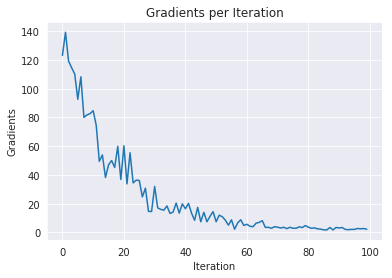

In [30]:
plotGradients(gradientsRNN)

As you can see, the gradients decay as time progresses. This is one of the factors that makes simple RNNs more difficult to train compared to LSTMs.

#### The Gradient Dynamics of LSTMs:

Next, let's compare the same plot with LSTMs. Though this might not be very well known, the original formulation of the LSTM did not have a forget gate; we'll be using the formulation without the forget gate first and then see how the forget gate changes the dynamics.

In [31]:
lstm = NaiveLSTM(input_size=50, hidden_size=125)

In [32]:
# GOAL: does the forward pass of lstm calculation, but for one iteration
def lstmStep(x_t:Tensor, h_t: Tensor, c_t:Tensor, 
             W_ii:Tensor, W_hi:Tensor, b_i:Tensor,
             W_if:Tensor, W_hf:Tensor, b_f:Tensor,
             W_ig:Tensor, W_hg:Tensor, b_g:Tensor,
             W_io:Tensor, W_ho:Tensor, b_o:Tensor,
             useForgetGate = False):
    
    # calculate input gate: 
    i_t = torch.sigmoid(x_t @ W_ii + h_t @ W_hi + lstm.b_i)
    
    if useForgetGate:
        # forget gate variable calculation: 
        f_t = torch.sigmoid(x_t @ W_if + h_t @ W_hf + lstm.b_f)
    
    # g-gate
    g_t = torch.tanh(x_t @ W_ig + h_t @ W_hg + lstm.b_g)
    # output gate variable
    o_t = torch.sigmoid(x_t @ W_io + h_t @ W_ho + lstm.b_o)
    
    if useForgetGate:
        c_t = f_t * c_t + i_t * g_t 
    else: 
        c_t = c_t + i_t * g_t 
        
    h_t = o_t * torch.tanh(c_t)
    
    return h_t, c_t 
    

In [46]:
# Generate the lstm steps
h_0, c_0 = (torch.zeros(lstm.hidden_size, requires_grad=True),
            torch.zeros(lstm.hidden_size, requires_grad=True))

gradientsLSTM = []

h_t, c_t = h_0, c_0 # initialization

for t in range(NUM_ITERS):
    h_t, c_t = lstmStep(
        x_t = testEmbeddings[: ,t, :],  h_t = h_t, c_t = c_t, 
        W_ii = lstm.W_ii, W_hi = lstm.W_hi, b_i = lstm.b_i, 
        W_if = lstm.W_if, W_hf = lstm.W_hf, b_f = lstm.b_f, 
        W_ig = lstm.W_ig, W_hg = lstm.W_hg, b_g = lstm.b_g, 
        W_io = lstm.W_io, W_ho = lstm.W_ho, b_o = lstm.b_o,
        useForgetGate=False
    )
    
    # Calculate loss
    loss = h_t.abs().sum() # use L1 norm
    loss.backward(retain_graph=True)
    
    gradientsLSTM.append(torch.norm(h_0.grad).item())
    
    h_0.grad.zero_()
    lstm.zero_grad()

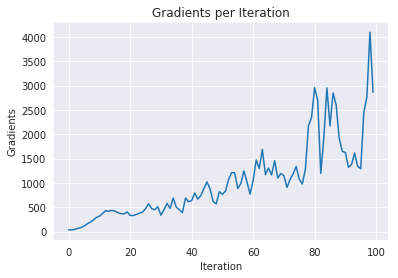

In [47]:
# NOte how gradient is accumulating
# TODO (?): gradients for c_t propagate back to the gradients for c_t-1
# Also the influence of the initial state c_t will influence future states c_t+1
plotGradients(gradientsLSTM)

Notice how the gradient keeps on accumulating. The reason the gradient behaves this way is because of the update rule of the LSTM: 

$$
c_t = c_{(t-1)} + i_t * g_t
$$

From gradient calculus, that the gradients for $ c_t $ propagate straight back to the gradients for $ c_{t-1} $. Therefore, the gradient of the initial timestep keeps increasing: since $ c_0 $ influences $ c_1 $, which in turn influences $ c_2 $, and so on, the influence of the initial state never disappears.

Of course, this can be a mixed blessing: sometimes we don't want the current timestep to influence the hidden state 200 steps into the future. Sometimes, we want to "forget" the information we learned earlier and overwrite it with what we have newly learned. This is where the forget gate comes into play.

#### Turning the Forget Gate On

##### CASE 2: LSTM gradient analysis with: forget gate (YES) and initial bias (ones)

In [ ]:
# Here: must initialize the bias of the forget gate to 1
lstm.b_f.data = torch.ones_like(lstm.b_f.data)

In [49]:
#print(lstm.b_f.data)
print(lstm.b_f)
print(lstm.b_f.dim())
print(lstm.b_f.shape)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True)
1
torch.Size([125])


In [50]:
# Generate the lstm steps
h_0, c_0 = (torch.zeros(lstm.hidden_size, requires_grad=True),
            torch.zeros(lstm.hidden_size, requires_grad=True))

gradientsLSTM_forget = []

h_t, c_t = h_0, c_0 # initialization

for t in range(NUM_ITERS):
    h_t, c_t = lstmStep(
        x_t = testEmbeddings[: ,t, :],  h_t = h_t, c_t = c_t,
        W_ii = lstm.W_ii, W_hi = lstm.W_hi, b_i = lstm.b_i,
        W_if = lstm.W_if, W_hf = lstm.W_hf, b_f = lstm.b_f,
        W_ig = lstm.W_ig, W_hg = lstm.W_hg, b_g = lstm.b_g,
        W_io = lstm.W_io, W_ho = lstm.W_ho, b_o = lstm.b_o,
        useForgetGate=True
    )

    # Calculate loss
    loss = h_t.abs().sum() # use L1 norm
    loss.backward(retain_graph=True)

    gradientsLSTM_forget.append(torch.norm(h_0.grad).item())

    h_0.grad.zero_()
    lstm.zero_grad()

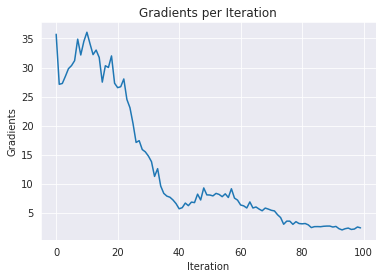

In [51]:
# The gradients decay more slowly than for RNN (when initializing the forget gate bias to 1) 
plotGradients(gradientsLSTM_forget)

##### CASE 3: LSTM gradient analysis with: forget gate (YES) and initial bias (NO)

In [52]:
#When we don't innitialize the forget gate bias to 1 WHILE using forget gate = True
lstm.b_f.data = torch.zeros_like(lstm.b_f.data)

In [53]:
# Generate the lstm steps
h_0, c_0 = (torch.zeros(lstm.hidden_size, requires_grad=True),
            torch.zeros(lstm.hidden_size, requires_grad=True))

gradientsLSTM_forget_zeroBias = []

h_t, c_t = h_0, c_0 # initialization

for t in range(NUM_ITERS):
    h_t, c_t = lstmStep(
        x_t = testEmbeddings[: ,t, :],  h_t = h_t, c_t = c_t,
        W_ii = lstm.W_ii, W_hi = lstm.W_hi, b_i = lstm.b_i,
        W_if = lstm.W_if, W_hf = lstm.W_hf, b_f = lstm.b_f,
        W_ig = lstm.W_ig, W_hg = lstm.W_hg, b_g = lstm.b_g,
        W_io = lstm.W_io, W_ho = lstm.W_ho, b_o = lstm.b_o,
        useForgetGate=True
    )

    # Calculate loss
    loss = h_t.abs().sum() # use L1 norm
    loss.backward(retain_graph=True)

    gradientsLSTM_forget_zeroBias.append(torch.norm(h_0.grad).item())

    h_0.grad.zero_()
    lstm.zero_grad()

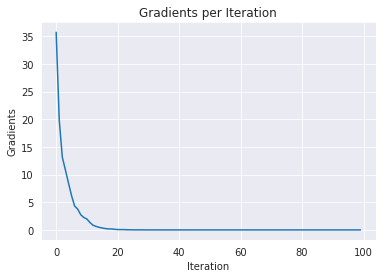

In [54]:
# The gradients decay much faster than RNN  and faster than previous LSTM 
# (because we set forget gate bias to zero tensor)
# KEY POINT: this is why initializing the forget gate to 1 is important, at least in initial
# stages of training. 
plotGradients(gradientsLSTM_forget_zeroBias)

##### CASE 4: LSTM gradient analysis with: forget gate (YES) and initial bias (-1)

In [55]:
lstm.b_f.data = - torch.ones_like(lstm.b_f.data)
lstm.b_f.data

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [57]:
# Generate the lstm steps
h_0, c_0 = (torch.zeros(lstm.hidden_size, requires_grad=True),
            torch.zeros(lstm.hidden_size, requires_grad=True))

gradientsLSTM_forget_negBias = []

h_t, c_t = h_0, c_0 # initialization

for t in range(NUM_ITERS):
    h_t, c_t = lstmStep(
        x_t = testEmbeddings[: ,t, :],  h_t = h_t, c_t = c_t,
        W_ii = lstm.W_ii, W_hi = lstm.W_hi, b_i = lstm.b_i,
        W_if = lstm.W_if, W_hf = lstm.W_hf, b_f = lstm.b_f,
        W_ig = lstm.W_ig, W_hg = lstm.W_hg, b_g = lstm.b_g,
        W_io = lstm.W_io, W_ho = lstm.W_ho, b_o = lstm.b_o,
        useForgetGate=True
    )

    # Calculate loss
    loss = h_t.abs().sum() # use L1 norm
    loss.backward(retain_graph=True)

    gradientsLSTM_forget_negBias.append(torch.norm(h_0.grad).item())

    h_0.grad.zero_()
    lstm.zero_grad()

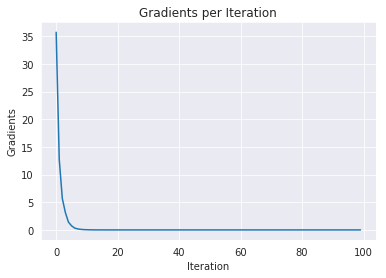

In [58]:
# The weights decay even faster
plotGradients(gradientsLSTM_forget_negBias)

The weights decay even faster now.

We looked at a lot of charts, but the most important point is that the LSTM basically has control over how much of the gradient to allow to flow through each timestep. This is what makes them so easy to train.

## Making the LSTM Faster

Remember how slow our implementation of the LSTM was slow? Let's see how we can speed it up.

If you look at the code for our LSTM carefully, you'll notice that there is a lot of shared processing that could be batched together. For instance, the input and forget gates are both computed based on a linear transformation of the input and the hidden states.

We can group these computations into just two matrix multiplications. The code now looks like this:

## Making the LSTM Faster

Remember how slow our implementation of the LSTM was slow? Let's see how we can speed it up.

If you look at the code for our LSTM carefully, you'll notice that there is a lot of shared processing that could be batched together. For instance, the input and forget gates are both computed based on a linear transformation of the input and the hidden states.

We can group these computations into just two matrix multiplications. The code now looks like this: